# Ch4.The Unreasonable Effectiveness of Linear Regression

이번 장에서는 중요한 편향 제거 기법인 선형회귀(Linear Regression)과 최소제곱법(Ordinary Least Sqaure,OLS), 직교화(Orthogonalization)를 다룬다. 처치와 결과 사이의 관계를 추정할 때 선형회귀분석을 사용하면 교란 요인의 영향을 보정하는데 도움이 되는지 알아본다. 더 나아가 처치 직교화라는 강력한 개념도 배운다. 해당 개념은 선형회귀에서 비롯되었으며, 나중에 인과추론에 머신러닝 모델을 적용할 때 유용하게 사용된다.

In [54]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import graphviz as gr
import matplotlib
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns

style.use("ggplot")
import statsmodels.formula.api as smf
from cycler import cycler

---

## 4.1 인과추론에서 선형회귀의 필요성

회귀분석은 데이터 과학을 배우는 사람들이 배우는 기본적인 모델 중 하나이며, 비교적 단순하다. 회귀분석은 100년이 넘은 역사를 가진 모델임에도 인과추론에서 여전히 강력한 도구이다. 회귀분석은 인과추론의 핵심이자 가장 많이 사용되는 방법이다. 또한 회귀분석은 추후 배울 대부분의 패널데이터 방법(이중 차분법,DID), 이원고정효과(Two-Way Fixed Effects,TWFE), 머신러닝 방법(이중/편향 제거 머신러닝) 그리고 다른 식별 기법(도구변수,불연속 설계)등 응용 방법론의 주요 구성 요소이기도 하다.

### 모델이 필요한 이유

은행이나 대부 업계에서 대출 금액이나 신용한도가 채무불이행률에 미치는 영향을 알아보려고 한다. 당연히 신용한도를 늘리면 신용카드 대금을 미납할 확률이 높아질 것이다. 하지만 실제 은행 데이터를 살펴보면 신용 한도와 채무불이행률 사이에는 음의 상관관계가 존재한다. 물론 신용 한도를 높일수록 고객의 채무불이행률이 줄어든다는 뜻은 아니다. 오히려, 이는 은행과 대출 회사들이 자체 심사 모델에 따라 채무불이행 가능성이 낮다고 판단되는 고객에게 더 높은 신용 한도를 설정하는 **처치 배정 메커니즘**을 반영한다는 뜻이다.

지금 나타난 음의 상관관계는 교란편향의 영향 때문이다.

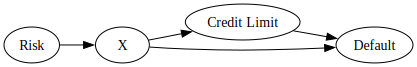

In [55]:
g_risk = gr.Digraph(graph_attr={"rankdir":"LR"})

g_risk.edge("Risk", "X")
g_risk.edge("X", "Credit Limit")
g_risk.edge("X", "Default")
g_risk.edge("Credit Limit", "Default")

g_risk

물론 은행은 고객의 채무불이행에 대한 고유 위험을 알 수 없지만, 소득이나 신용점수 같은 대리변수 $X$를 사용하여 이를 추정할 수 있다. 
$$
ATE = E_x\{E[Y|T=1,X=x]-E[Y|T=0,X=x]\}
$$

여기에 조건부 독립성 가정 $(Y_0,Y_1) \perp T\ |X$이 만족되면 인과효과를 식별할 수 있다.

그러나 해당 보정 공식을 그대로 적용하면 데이터를 특성 $X$에 따라 여러 그룹으로 나눠야 하고, 이는 이산형 변수가 적을 때는 문제가 되지 않지만, 변수가 많고 그 중 일부가 연속형이라면 **차원의 저주(Curse of Dimensionality)** 가 발생한다. 예를 들어, 은행이 고객을 평가하고 신용 한도를 배정할 때 10개의 변수를 사용하고, 각 변수에 3개의 그룹이 있다고 가정해본다. 이것만으로도 $3^{10}=59049$개의 셀이 생성된다. 각 셀에서 $ATE$를 추정하고 각 결과의 평균값을 구하려면 엄청난 양의 데이터가 있을 때만 가능하다. 차원의 저주 때문에 공변량이 많을 때 보정 공식을 그대로 적용하면 **희소성(Sparsity) 문제**가 발생할 수 있다.

차원의 저주를 해결하는 방법은 **잠재적 결과를 선형회귀 같은 방식으로 모델링**할 수 있다고 가정하고, $X$로 정의된 각각의 셀을 **내삽(Interpolate)** 하고 **외삽(Extrapolate)** 하는 것이다. 이 알고리즘은 결과변수를 $X$ 변수로 투영한 후, 이 투영된 값들을 바탕으로 실험군과 대조군을 비교한다. 회귀분석을 충분히 이해하기 위해 먼저 A/B 테스트와 회귀분석의 관계를 알아본다.

### A/B 테스트와 회귀분석의 관계

온라인 스트리밍 회사에서 추천 시스템을 개선한다고 가정해보자. 관리자 입장에서는 새로운 추천 시스템이 스트리밍 서비스의 시청 시간을 늘릴 수 있는지 궁금할 것이다. 이를 시험해보려고 A/B 테스트를 진행한다. 먼저 고객층을 대표할 일부 고객 표본을 추출하고, 그 다음 표본에서 무작위로 1/3을 골라 새 추천 시스템을 적용하고 나머지는 이전 버전의 추천 시스템을 계속 사용하게 한다. 한 달 후, 하루 평균 시청 시간 결과를 수집한다.

In [56]:
import pandas as pd
import numpy as np

url='https://raw.githubusercontent.com/matheusfacure/causal-inference-in-python-code/main/causal-inference-in-python/data/rec_ab_test.csv'

data=pd.read_csv(url)

data.head()

,recommender,age,tenure,watch_time
0,challenger,15,1,2.39
1,challenger,27,1,2.32
2,benchmark,17,0,2.74
3,benchmark,34,1,1.92
4,benchmark,14,1,2.47


추천 시스템의 버전이 **무작위**로 배정되었으므로 버전 간의 평균 시청 시간을 단순한 비교만으로도 $ATE$를 알 수 있다. 그러나 통계적 유의성을 확인하려고 표준오차를 계산하여 신뢰구간을 구하는 번거로운 과정을 거쳐야 한다. 그런데 A/B 테스트 결과를 회귀분석으로 해석하면, 필요한 모든 추론 통계량(inference statistic)을 바로 얻을 수 있다. 회귀분석의 기본 아이디어는 다음과 같은 모델을 추정하는 것이다.
$$
WatchTime_i=\beta_0 + \beta_1 challenger_i+e_i
$$

여기서 $challenger$는 새로운 추천 시스템이 적용되면 1, 아니면 0이다. 이 모델을 추정하는 경우, 새로운 버전의 효과는 $\beta_1$의 추정값인 $\hat{\beta_1}$이 된다.

파이썬에서 회귀 모델을 실행하려면 `statsmodels` 패키지 API를 사용하면 된다. 이를 사용하면 R 스타일 수식을 사용하여 선형모델을 간결하게 표현할 수 있다. 예를 들어 앞의 모델을 `'watch_time~C(recommender)`로 표현할 수 있다. 모델을 추정하려면 `.fit()` 메서드를, 결과를 불러오려면 `.summary()` 메서드를 사용하면 된다.

In [57]:
import statsmodels.formula.api as smf

result = smf.ols('watch_time ~ C(recommender)',data=data).fit()

result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.0491,0.058,35.367,0.000,1.935,2.163
C(recommender)[T.challenger],0.1427,0.095,1.501,0.134,-0.044,0.330


`recommender` 변수는 범주가 두 개(새로운 버전의 추천 시스템과 기존 버전)인 범주형 변수이다. 열이 범주형임을 나타내려면 해당 변수를 `c(...)`으로 묶어주면 된다.

다음으로 결과를 살펴본다. 먼저, 절편(intercept)은 바로 모델의 $\beta_0$에 대한 추정값이다. 모델의 다른 변수가 0일 때 결과의 기댓값을 알려준다. 여기서 유일하게 다른 변수는 추천 시스템이 새로운 버전인지에 대한 지표이므로, 이 절편은 이전 버전의 추천 시스템을 사용한 고객들의 예상 시청 시간으로 해석할 수 있다. 즉, 기존 버전의 추천 시스템을 사용했을 때 고객이 하루 평균 2.04시간 동안 스트리밍 콘텐츠를 시청한다는 의미이다.

다음으로 $\beta_1$의 추정값을 살펴본다. 이는 새로운 추천 시스템과 관련된 매개변수이다. 이를 보면 새로운 버전 사용에 따른 시청 시간 증가를 볼 수 있다. $\hat{\beta_0}$가 기존 추천 시스템에서의 시청 시간 추정값이라면, $\hat{\beta_0}+\hat{\beta_1}$은 새로운 버전을 이용한 고객 시청 시간의 추정값이다. 즉, **$\hat{\beta_1}$은 $ATE$에 대한 추정값이다.** 무작위 배정 덕분에, 이 추정값에 인과적 의미를 부여할 수 있다. 결과적으로, 새로운 추천 시스템이 평균적으로 하루 시청 시간을 0.14시간 정도 늘렸다. 하지만 이 결과는 통계적으로 유의하지 않다.

결과가 유의하지는 않지만, 이를 통해 $ATE$를 추정했을 뿐만 아니라 동시에 신뢰구간과 *p-value*도 얻었다. 더불어 회귀분석의 원래 목적인 각 처치에 대한 $E[Y|T]$를 추정할 수 있다.

In [58]:
data.groupby('recommender')['watch_time'].mean(())

recommender
benchmark     2.049064
challenger    2.191750
Name: watch_time, dtype: float64

앞서 보았듯이, 절편은 수학적으로 대조군(기존 버전의 추천 시스템)에 속한 사용자의 평균 시청시간과 동일하다.  
이는 여기서 회귀분석이 평균을 비교하는 것과 수학적으로 동일하기 때문이다. 결과적으로 $\hat{\beta_1}$이 두 그루 간의 평균 차이인 2.191 - 2.049 = 0.1427을 의미한다. 그래서 실제로 회귀분석으로 그룹 평균을 재현할 수 있다.

### 회귀분석을 통한 보정

신용 한도가 채무불이행률에 미치는 영향을 추정하는 상황으로 돌아가서 회귀분석의 영향을 이해해본다. 은행 데이터는 보통 신용 가치를 나타낼 수 있는 고객 특성들(월급,신용 점수,...)과 해당 고객에게 주어진 신용한도(처치변수), 고객의 채무불이행 여부(결과변수)를 포함한다.

In [59]:
url ='https://raw.githubusercontent.com/matheusfacure/causal-inference-in-python-code/main/causal-inference-in-python/data/risk_data.csv'

risk_data = pd.read_csv(url)
risk_data.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,default
0,950.0,11,16,1,500.0,518.0,3200.0,0
1,780.0,11,7,1,414.0,429.0,1700.0,0
2,1230.0,14,9,1,586.0,571.0,4200.0,0
3,1040.0,15,8,1,379.0,411.0,1500.0,0
4,1000.0,16,1,1,379.0,518.0,1800.0,0


여기서 처치인 `credit_limit`은 너무 많은 범주를 포함한다. 이러한 상황에서 범주형이 아닌 연속형을 처리하는 것이 좋다.

In [60]:
print(risk_data.shape)
risk_data[['credit_limit']].nunique()

(50000, 8)


credit_limit    83
dtype: int64

$ATE$를 여러 처치 수준 간의 차이로 표현하는 대신, 기대 결과의 처치에 대한 **도함수(derivative)** 로 표현할 수 있다.
$$
ATE = \frac{\partial }{\partial t}E[y|t]
$$

이는 단순히 처치가 한 단계 증가할 때 결과가 얼마나 변할지에 대한 기댓값이다. 이 사례에서는 신용한도가 1 달러 증가했을 때 채무불이행률이 얼마나 변할지에 대한 기댓값을 나타낸다.

이런 추정량을 추정하는 한 가지 방법은 회귀분석을 이용하는 것이다. 구체적으로 다음과 같은 모델을 추정하면 된다.
$$
Default_i = \beta_0+\beta_1CreditLim_i+e_i
$$
그리고 추정된 $\hat{\beta_1}$은 신용한도가 1달러 증가할 때 채무불이행률이 얼마나 변할지에 대한 기대값이다. 신용 한도가 무작위로 배정되었다면, 이 매개변수를 인과적으로 해석할 수 있지만, 은행이 무작위로 신용 한도를 배정하지 않으므로, 그렇지 않다는 것을 잘 안다. 실제로 앞의 모델을 실행하면 $\beta_1$에 대한 음의 추정값을 얻게 된다.

In [61]:
model = smf.ols('default~ credit_limit',data=risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2192,0.004,59.715,0.000,0.212,0.226
credit_limit,-2.402e-05,1.16e-06,-20.689,0.000,-2.63e-05,-2.17e-05


교란으로 인해 채무불이행률과 신용 한도가 음의 상관관계가 되었다. 신용 한도별 평균 채무불이행률과 함께 적합된 회귀선을 시각화하면 음의 추세가 명확하게 보인다.

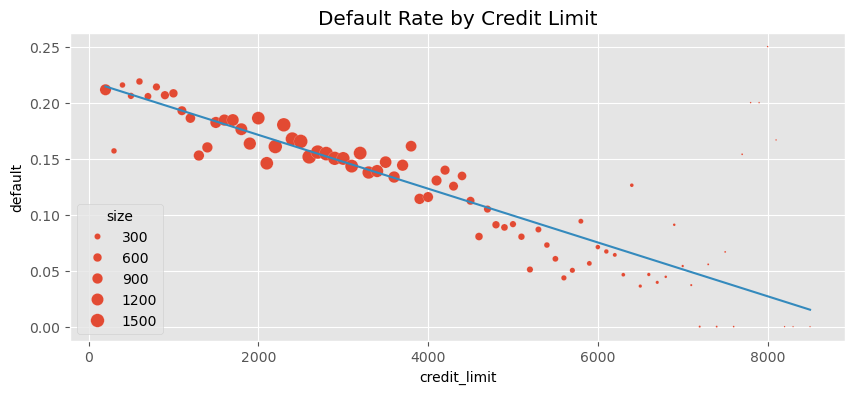

In [62]:
plt_df = (risk_data
          .assign(size=1)
          .groupby("credit_limit")
          .agg({"default": "mean", "size":sum})
          .reset_index()
          .assign(prediction = lambda d: model.predict(d)))

plt.figure(figsize=(10,4))

sns.scatterplot(data=plt_df,
                x="credit_limit",
                y="default",
                size="size",
                sizes=(1,100))

plt.plot(plt_df["credit_limit"], plt_df["prediction"], color="C1")
plt.title("Default Rate by Credit Limit")

plt.show()

해당 편향을 보정하려면, 이론적으로 모든 교란 요인에 따라  
- 1. 데이터를 나누고  

- 2. 나눈 각 그룹 내에서 채무불이행률을 신용 한도에 회귀선을 적합시키고  

- 3. 계수를 추출하여 결과의 평균을 구하면 된다.  

하지만 차원의 저주로 인해, 적절한 수의 교란 요인(두 가지 신용점수)을 고려했을 때조차 다음처럼 표본이 하나뿐인 셀이 존재한다. 해당 표본으로는 회귀모델을 만들 수 없으며, 많은 셀이 비어 있다.

In [63]:
risk_data.groupby(['credit_score1','credit_score2']).size().head()

credit_score1  credit_score2
34.0           339.0            1
               500.0            1
52.0           518.0            1
69.0           214.0            1
               357.0            1
dtype: int64

다행히 회귀분석을 통해 이 상황을 해결할 수 있다. 교란 요인을 직접 보정하는 대신, *OLS*로 추정할 모델에 단순히 교란 요인을 추가하면 된다.
$$
Default_i=\beta_0+\beta_1CreditLim_i+\theta X_i + e_i
$$

여기서 $X$는 교란 요인 벡터이고, $\theta$는 해당 교란 요인과 관련된 매개변수 벡터이다. 매개변수 $\theta$는 특별하지 않고 $\beta_1$과 똑같이 작동한다. 다르게 표현된 이유는 단순히 편향되지 않은 $\beta_1$의 추정값을 얻는 데 사용되는 매개변수이기 때문이다. 즉, 이 매개변수의 인과관계 해석에는 크게 신경 쓰지 않아도 되며, 이런 매개변수를 **장애모수(nuisance parameter)** 라고 부른다.

신용 한도 예제에서는 신용점수와 임금을 교란 요인으로 모델에 추가할 수 있다. 그러면 모델을 다음과 같이 만들 수 있다.
$$
Default_i = \beta_0+\beta_1CreditLim_i+\theta_1wage_i+\theta_2CreditScore1_i+\theta_3CreditScore2_i+e_i
$$

앞의 모델은 $E[y|t,X]$에 대한 것이고, 원하는 모델은 $\frac{\partial }{\partial t}E[y|t,X]$이다. 이 모델을 처치인 신용 한도에 대해 미분하면 $\beta_1$이 나온다. 그리고 $\beta_1$은 신용 한도에 대한 채무불이행률 기댓값의 편도함수라고 볼 수 있다. 직관적으로, **모델의 다른 모든 변수가 고정된 상태에서** 신용 한도를 조금 늘렸을 때 채무불이행률이 얼마나 변할지에 대한 기댓값이다. 회귀분석이 처치와 결과 사이의 관계를 추정하는 동안 교란 요인을 고정한다는 것을 알 수 있다.

몇 가지 교란 요인을 추가하면 신용 한도와 채무불이행 사이의 관계가 **양수**로 바뀐다.

In [64]:
formula = 'default ~ credit_limit + wage + credit_score1 + credit_score2'
model = smf.ols(formula,data = risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4037,0.009,46.939,0.000,0.387,0.421
credit_limit,3.063e-06,1.54e-06,1.987,0.047,4.16e-08,6.08e-06
wage,-8.822e-05,6.07e-06,-14.541,0.000,-0.000,-7.63e-05
credit_score1,-4.175e-05,1.83e-05,-2.278,0.023,-7.77e-05,-5.82e-06
credit_score2,-0.0003,1.52e-05,-20.055,0.000,-0.000,-0.000


신용 한도는 1000 단위이고, 채무불이행 여부는 0 또는 1이기 때문에 $\beta_1$의 작은 추정값에 신경 쓸 필요는 없다. 신용 한도를 1달러씩 늘렸을 때 채무불이행률이 증가하는 정도는 아주 작을 것이다. 하지만 이 추정값은 통계적으로 유의하고 신용 한도를 늘릴수록 채무불이행률이 증가하는 것을 알려준다. 교란 요인을 통제함으로써 결과가 우리의 직관과 더 맞게 바뀌었다.

본격적으로 **프리슈-워-로벨(Frish-Waugh-Lovell,FWL) 정리**를 다룬다. 이 정리는 편향을 제거하는 방법이지만, 데이터 과학자에게 많이 알려지지 않았다. *FWL* 정리는 고급 편향 제거 기법을 이해하는 데 꼭 필요하며, **편향을 제거하는 전처리 단계에서 사용**할 수 있기 때문에 매우 유용하다.

은행 예제로 돌아가서, 은행의 많은 데이터 분석가는 신용 한도가 위험뿐 아니라 다양한 사업 지표에 영향을 미치는지(원인이 되는지) 알고 싶다고 하자. 그러나 신용 한도가 어떻게 배정되었는지는 우리만이 아는 상황이다. FWL 정리를 사용함으로써 이러한 지식을 바탕으로 신용 한도 데이터의 편향을 제거하고, 편향이 제거된 데이터를 사용하도록 할 수 있다. 즉, **FWL 정리는 편향 제거 단계와 영향 추정 단계를 분리할 수 있게 해준다.** 이 정리를 배우기 전에 먼저 회귀분석 이론을 간단히 복습한다.

---

## 4.2 회귀분석 이론

여기선 간단하게 회귀분석의 이론을 파악한다. 우선, 회귀분석은 선형 예측 문제를 가장 잘 해결한다. 다음 식에서 $\beta^{*}$를 매개변수 벡터라고 한다.
$$
\beta^{*} = \underset{\beta}{argmax}\ E[(Y_i-X_i'\beta)^2]
$$
선형회귀분석은 평균제곱오차(Mean Squared Error,MSE)를 최소화하는 매개변수를 찾는다. 이를 미분하고 그 결과를 0으로 두면, 이 문제에 대한 선형 해(solution)는 다음과 같다.
$$
\beta^{*} = E[X'X]^{-1}E[X'Y]
$$
표본을 통해 다음과 같이 회귀계수를 추정할 수 있다.
$$
\hat{\beta}=(X'X)^{-1}X'Y
$$

앞서 배운 수식을 통해, 이를 코드로 구현한다. 다음 코드에서는 *OLS*의 대수적 해를 사용해서 앞 모델의 매개변수를 추정한다(마지막 변수로 절편을 추가했으니 첫 번째 매개변수 추정값은 $\hat{\beta_1}$이 된다).

In [65]:
X_cols = ['credit_limit','wage','credit_score1','credit_score2']
X = risk_data[X_cols].assign(intercept=1).to_numpy()                ##to_numpy()는 같은 결과 형식 출력을 위한 코드
y = risk_data['default'].to_numpy()


## method 1 : @ 연산자 사용
def regression_1(X,y):
    beta = np.linalg.inv(X.T @ X) @ X.T @ y
    return beta

## method 2 : .dot() 함수 사용
def regression_2(X,y):
    return np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

## method 3 : lstsq() 함수 사용
def regression_3(X,y):
    beta, *_ = np.linalg.lstsq(X,y,rcond=None)
    return beta

print(regression_1(X,y))
print(regression_2(X,y))
print(regression_3(X,y))

[ 3.06252773e-06 -8.82159125e-05 -4.17472814e-05 -3.03928359e-04
  4.03661277e-01]
[ 3.06252773e-06 -8.82159125e-05 -4.17472814e-05 -3.03928359e-04
  4.03661277e-01]
[ 3.06252773e-06 -8.82159125e-05 -4.17472814e-05 -3.03928359e-04
  4.03661277e-01]


앞서 `statsmodels`의 `ols` 함수를 사용하여 모델을 추정할 때 얻은 값과 같다. 모두 같은 결과를 출력하는 3가지 방법이 있지만, 1,2번은 직접적으로 역행렬을 계산하기 때문에 만약 $X^TX$가 역행렬이 존재하지 않는 특이행렬에 가까우면($X$의 열들이 종속적인 경우) 불안정한 반면, `lstsq()` 함수를 사용하면 **특이값 분해**를 사용하므로 좀 더 안정적이다.

<div style="border: 2px solid rgb(233, 224, 222); padding: 10px; background-color: rgb(233, 224, 222); margin: 10px 0;">
    <strong style="font-weight: bold;">● <code>assign</code> 메서드</strong><br>
    판다스의 <code>.assign()</code> 메서드는 새로 만든 열을 전달하여 새로운 데이터프레임을 반환하는 기능이라고 생각하면 된다.
</div>

### 단순선형회귀

이전 절에서 설명한 $\hat{\beta_1}$ 공식은 일반화된 버전이다. 그러나 단일 설명변수만 있는 경우를 학습하는 것도 도움이 된다. 인과추론에서는 변수 $T$가 결과 $Y$에 미치는 인과효과를 추정하려는 경우가 많다. 단순선형회귀분석을 통해 이 효과를 추정할 수 있다.

단일 설명변수 $T$를 사용할 때 관련된 매개변수는 다음과 같다.
$$
\hat{\tau} = \frac{Cov(Y_i,T_i)}{Var(T_i)} = \frac{E[(T_i-\bar{T})(Y_i-\bar{Y})]}{E[(T_i-\bar{T})^2]}
$$
$T$가 무작위로 배정된 경우 $\beta_1$은 $ATE$이다. 중요한 점은 이 간단한 공식을 보고 회귀분석이 어떤 역할을 하는지 확인할 수 있다. 회귀분석은 처치와 결과가 어떻게 함께 움직이는지(분자의 공분산으로 표현)를 파악하고 이를 처치 대상에 따라 조정한다. 이 매개변수는 처치와 결과에 대한 공분산을 처치의 분산으로 나눔으로써 얻을 수 있다.

<div style="border: 2px solid rgb(233, 224, 222); padding: 10px; background-color: rgb(233, 224, 222); margin: 10px 0;">
    β를 추정하는 일반적인 공식과 이 식을 연결지을 수 있다. 공분산은 dot product와 밀접한 관련이 있으므로, 공분산/분산 공식에서 X'X가 분모 역할을 하고 X'y가 분자 역할을 한다고 볼 수 있다.
</div>

### 다중선형회귀

설명변수가 두 개 이상일 때는 단순선형회귀를 확장하면 된다. 다른 변수는 보조적인 변수일 뿐이고 진짜 관심 있는 부분은 $T$와 관련된 매개변수 $\tau$를 추정하는 것으로 생각해본다.
$$
y_i = \beta_0 + \tau T_i + \beta_1 X_{1i} + ... + \beta_k X_{ki} + u_i
$$

$\tau$는 다음 공식으로 추정할 수 있다.
$$
\hat{\tau} = \frac{Cov(Y_i,\tilde{T_i})}{Var(\tilde{T_i})}
$$

여기서 $\tilde{T_i}$는 $T_i$를 모든 공변량 $X_{1i},X_{2i},...,X_{ki}$로 $T_i$를 설명하는 회귀식에서 나온 잔차이다.

수식으로 표현하면,  
$$
\hat{T_i} = \theta_0+\theta_1X_{1i}+\theta_2X_{2i}+...+ \theta_{ki}X_{ki}
$$
으로 $\hat{T_i}=E[T_i|X_i]$를 추정한다. $\hat{T_i}$는 통제변수들인 $X_1,X_2...,X_k$가 설명해주는 $T$의 부분이라 생각하면 된다. 여기서 $\tilde{T_i}$는 $T_i-\hat{T_i}$이다.  
**이는 $\boldsymbol{T}$에서 $\boldsymbol{X}$들에 의해 설명되는 부분을 제거한, $\boldsymbol{X}$에 대해 독립적인 부분만 남은 $T$이다.**

다중회귀분석에서 회귀계수의 의미는 **모델의 다른 변수들의 효과를 고려한 후** 얻은 동일 설명변수의 이변량(bivariate) 계수라는 것이다. 인과추론 관점에서 보면 $\tau$는 다른 모든 변수를 활용해 $T$를 예측한 후 얻은 $T$의 이변량 계수이다.

직관적으로 볼 때, 다른 변수를 사용하여 $T$를 예측할 수 있다면 $T$는 무작위가 아니다. 그러나 모든 교란 요인 $X$를 통제하면 $T$를 무작위처럼 보이게 할 수 있다. 그러려면 선형회귀분석을 사용하여 교란 요인에서 $T$를 예측한 다음, $T$에서 해당 회귀에 대한 잔차를 빼주면 $\tilde{T}$가 된다. $T$를 예측하는 데 이미 사용한 변수인 $X$를 이용해서는 $\tilde{T}$를 예측할 수 없다. 아주 깔끔하게 $\tilde{T}$는 $X$의 다른 변수와 연관(상관관계)이 없는 버전의 처치이다.

이 부분이 바로 다음에 학습할 *FWL* 정리이다.

---

## 4.3 프리슈-워-로벨 정리와 직교화

*FWL* 스타일의 직교화(잔차화라고도 함)는 **가장 먼저 사용할 수 있는 편향 제거(debiasing) 기법**이다. 이는 간단하면서도 비실험 데이터를 처치가 무작위로 배정된 것처럼 보이게 한다. *FWL* 정리는 주로 선형회귀에 관한 것이며, *FWL* 스타일의 직교화는 더 넓은 맥락에서 적용되도록 확장되어었다. *FWL* 정리에 따르면 다중선형회귀분석은 한 번에 추정하거나 세 단계로 나누어 추정할 수 있다.

다음과 같이 채무불이행률 `default`를 `credit_limit`,`wage`,`credit_score1`,`credit_score2`에 대해 회귀모형을 만든다.

In [66]:
formula = 'default ~ credit_limit + wage + credit_score1 + credit_score2'

model = smf.ols(formula,data=risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4037,0.009,46.939,0.000,0.387,0.421
credit_limit,3.063e-06,1.54e-06,1.987,0.047,4.16e-08,6.08e-06
wage,-8.822e-05,6.07e-06,-14.541,0.000,-0.000,-7.63e-05
credit_score1,-4.175e-05,1.83e-05,-2.278,0.023,-7.77e-05,-5.82e-06
credit_score2,-0.0003,1.52e-05,-20.055,0.000,-0.000,-0.000


*FWL* 정리에 따르면 추정 과정을 다음과 같이 세 단계로 나눌 수 있다.  
- 1.**편향 제거 단계** : 처치 $T$를 교란 요인 $X$에 대해 회귀식을 만들어 처치 잔차 $\tilde{T}=T-\hat{T}$를 구한다.  

- 2.**잡음 제거 단계** : 결과 $Y$를 처치 변수 $T$가 제외된 교란 요인 $X$에 대해 회귀식을 만들어 결과 잔차 $\tilde{Y}=Y-\hat{Y}$를 구한다.  

- 3.**결과 모델 단계** : $\tilde{Y}$를 $\tilde{T}$에 대해 회귀식을 만들어 $T$가 $Y$에 미치는 인과효과를 추정한다.

이 3 단계는 그 위의 다중선형회귀분석을 다시 설명한 것 뿐이다. *FWL* 정리는 추정 단계와 회귀 모델이 본질적으로 같음을 보여준다. 그리고 첫 번째 단계처럼 선형회귀의 편향 제거 구성 요소를 분리할 수 있음을 보여준다.

이 세 가지 단계를 좀 더 자세히 살펴본다.

###

### 1. 편향 제거 단계

정확한 인과효과 추정을 위해선 편향 제거 단계가 매우 중요하다. 신용 한도 예시에서, 교란편향의 영향으로 신용 한도에 따라 채무불이행률이 감소하는 추세를 보였다.

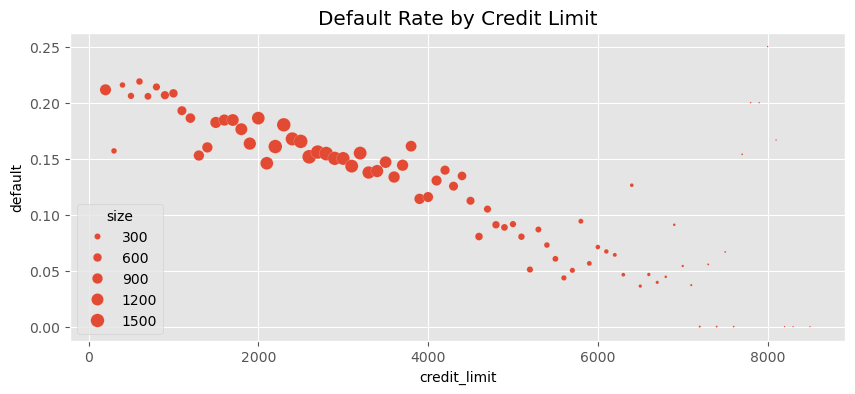

In [67]:
plt_df = (risk_data
          .assign(size=1)
          .groupby("credit_limit")
          .agg({"default": "mean", "size":sum})
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit",
                y="default",
                size="size",
                sizes=(1,100))


plt.title("Default Rate by Credit Limit")
plt.show()

*FWL* 정리에 따르면, 교란요인으로부터 처치인 신용 한도를 예측하는 회귀모델을 만들어 데이터의 편향을 제거할 수 있다.
$$
\widehat{CreditLim_i} = \theta_0+\theta_1X_{1i}+\theta_2X_{2i}+...+ \theta_{ki}X_{ki}
$$
그 다음 모델으로부터 신용한도에 대한 잔차 $\widetilde{CreditLim}$을 구한다.
$$
\widetilde{CreditLim_i} = CreditLim_i - \widehat{CreditLim_i}+(\ \overline{CreditLim}\ )
$$
이 잔차는 편향 제거 모델에 사용된 변수와는 상관관계가 없는 처치로 볼 수 있다. **예측값을 생성한 변수와 직교하기 때문이다.**

이 단계를 수행하면 0을 중심으로 한 $\widetilde{CreditLim}$이 만들어진다. 편향 제거에 필요없지만, 시각화를 위해 평균 처치인 $\overline{CreditLim}$을 추가해 원래의 $CreditLim$과 같은 범위에 둘 수도 있다.

In [68]:
debiasing_model = smf.ols('credit_limit~wage+credit_score1+credit_score2',
                          data=risk_data).fit()

risk_data_deb = risk_data.assign(
    credit_limit_res=(debiasing_model.resid+risk_data['credit_limit'].mean())
    
)

`default`를 편향이 제거된 처치인 $\widetilde{CreditLim}$으로 회귀분석을 실시하면, 편향 제거 모델에 사용된 교란 요인을 통제하면서 신용 한도가 채무불이행에 미치는 영향을 파악할 수 있다. 여기서 $\beta_1$에 대한 추정값 $\hat{\beta_1}$은 앞서 처치와 교란 요인을 모두 포함한 완전한 모델(Full-model)을 실행하여 얻은 값과 정확히 동일하다.

In [69]:
model_deb_data = smf.ols('default ~ credit_limit_res',data=risk_data_deb).fit()

model_deb_data.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1421,0.005,30.001,0.000,0.133,0.151
credit_limit_res,3.063e-06,1.56e-06,1.957,0.050,-4.29e-09,6.13e-06


하지만 자세히 살펴보면 *p-value*가 이전보다 약간 높다. 이는 분산 감소를 담당하는 잡음 제거 단계를 거치지 않았기 때문이다. 하지만 편향 제거 단계만 적용해도, 모든 교란 요인이 편향 제거 모델에 포함된다면 신용 한도가 채무불이행률에 미치는 인과적 영향에 대하여 편향되지 않은 추정값(*Unbiased estimate*)을 얻을 수 있다.

그래프를 보면, 편향되었을 때와 다르게 두 변수 사이의 관계가 음의 관계를 보이지 않는다.

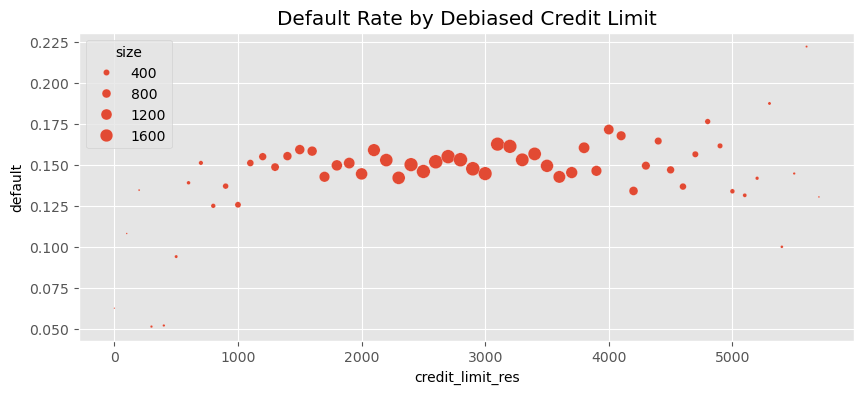

In [70]:
plt_df = (risk_data_deb
          .assign(size=1)
          .assign(credit_limit_res = lambda d: d["credit_limit_res"].round(-2))
          .groupby("credit_limit_res")
          .agg({"default": "mean", "size":sum})
          .query("size>30")
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit_res",
                y="default",
                size="size",
                sizes=(1,100))

plt.title("Default Rate by Debiased Credit Limit")
plt.show()

### 2. 잡음 제거 단계

잡음 제거는 편향 제거만큼 중요하진 않다. 잡음을 제거한다고 처치효과의 추정값이 바뀌지 않지만, 분산을 줄일 수 있다. 이 단계에서는 결과를 처치가 아닌 공변량에 대해 회귀식을 만든다.
$$
\widehat{default_i} = \beta_0+\beta_1X_{1i}+...\beta_kX_{ki}
$$
그 다음 결과에 대한 잔차를 얻는다.
$$
\widetilde{default_i} = default_i - \widehat{default_i}+(\ \overline{default}\ )
$$

In [71]:
denoising_model = smf.ols(
    'default ~ wage + credit_score1 + credit_score2',data=risk_data_deb
).fit()

risk_data_denoised = risk_data_deb.assign(
    default_res = denoising_model.resid + risk_data_deb['default'].mean()
)

#### 회귀 추정량의 표준오차

다음 단계로 가기 전에, 잡음과 관련해서 회귀 표준 오차의 계산법을 살펴본다. 추정한 회귀계수의 표준오차 공식은 다음과 같다.

$$
SE(\hat{\beta})=\frac{\sigma(\hat\epsilon)}{\sigma(\tilde{T})\sqrt{n-k}}
$$

여기서 $\hat{\epsilon}$은 회귀모델의 잔차이고, $n$은 샘플의 수, $k$는 절편을 포함한 파라미터의 개수이다.

표준오차를 코드로 확인해본다.

In [72]:
model_se = smf.ols(
    'default ~ wage + credit_score1 + credit_score2',
    data = risk_data
).fit()

print('SE regression:',model_se.bse['wage'])


model_wage_aux = smf.ols(
    'wage ~ credit_score1 + credit_score2',
    data = risk_data
).fit()

#모델의 자유도 : N-4
se_formula = (np.std(model_se.resid)
              / (np.std(model_wage_aux.resid)*np.sqrt(len(risk_data)-4))
              )

print('SE formula:',se_formula)

SE regression: 5.364242347548206e-06
SE formula: 5.364242347548192e-06


해당 식은 잡음 제거 단계를 직관적으로 이해하는 데 도움을 준다. 분자를 살펴보면, 결과를 잘 예측할수록 잔차가 작아지므로 추정값의 분산이 낮아진다. 또한 처치가 결과를 많이 설명하면 파라미터 추정값의 표준오차도 작아지는 것을 알 수 있다.

**오차는 직교화된 처치의 분산에 반비례한다.** 처치가 많이 바뀌면 그 영향을 측정하기가 더 쉬워진다.

#### 연속형 처치를 이용한 실험

표준오차 공식은 회귀분석에서 파라미터 추정값으로 효과를 측정하고자 하는 실험을 설계할때도 유용하다. 특히, 연속형 처치를 랜덤화하려는 경우에는 이 방법이 더 좋다. 이 경우에 표준오차 공식은 다음과 같이 근사할 수 있다.
$$
SE \approx \frac{\sigma(y)}{\sigma(T)\sqrt{n-k}}
$$

### 3. 최종 결과 모델

*FWL* 정리의 마지막 단계인 결과 모델에서는 두 잔차 $\tilde{Y}$와 $\tilde{T}$를 이용해서 회귀식을 만들면 된다.
$$
\hat{\tilde{Y_i}} =\gamma_0 + \gamma_1 \tilde{T_i}
$$

In [73]:
model_w_orthogonal = smf.ols('default_res ~ credit_limit_res',
                             data = risk_data_denoised).fit()

model_w_orthogonal.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1421,0.005,30.458,0.000,0.133,0.151
credit_limit_res,3.063e-06,1.54e-06,1.987,0.047,4.17e-08,6.08e-06


편향 제거 단계에서 얻은 파라미터 추정값은 신용한도와 다른 모든 공변량을 사용하여 회귀했을 때와 완전히 동일하다. 또한 표준오차의 *p-value*도 이제 모든 변수를 포함하여 처음 모델을 실행했을 때와 같다. 이것이 잡음 제거 단계의 효과이다. 다음은 편향이 제거된 처치, 잡음이 제거된 결과 간의 관계를 최종 모델의 예측값과 함께 표현한 그래프이다.

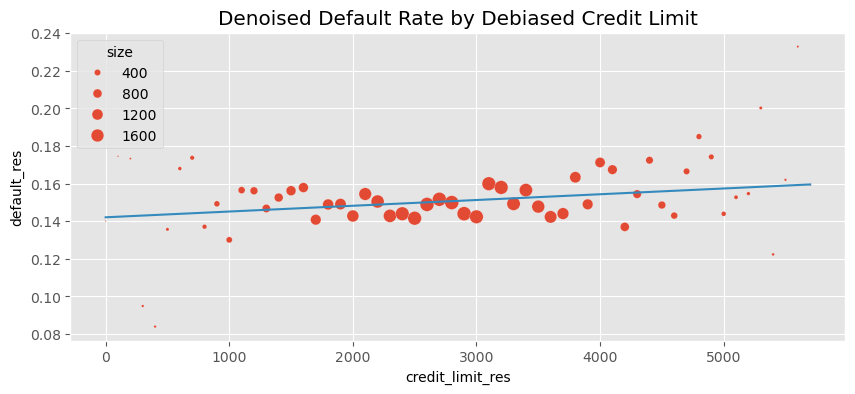

In [74]:
plt_df = (risk_data_denoised
          .assign(size=1)
          .assign(credit_limit_res = lambda d: d["credit_limit_res"].round(-2))
          .groupby("credit_limit_res")
          .agg({"default_res": "mean", "size":sum})
          .query("size>30")
          .reset_index()
          .assign(prediction = lambda d: model_w_orthogonal.predict(d)))

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit_res",
                y="default_res",
                size="size",
                sizes=(1,100))

plt.plot(plt_df["credit_limit_res"], plt_df["prediction"], c="C1")

plt.title("Denoised Default Rate by Debiased Credit Limit")
plt.show()

### *FWL* 정리 요약

*FWL* 정리를 시각적으로 이해해본다. 처치 $T$와 결과 $Y$ 사이의 관계를 추정하고 싶지만 교란요인 $X$가 있을 때, 처치는 $X$축, 결과는 $y$축에 표시하고 교란요인은 색을 사용해 표시한다.

처음에는 처치와 결과는 음의 기울기였지만, 도메인 지식에서 비롯된 확실한 근거로 볼 때, 양의 관계라고 확신하는 경우, 편향을 제거하고 인과효과를 추정한다.

이를 위해 먼저 선형회귀를 사용하여 $\hat{T}=E[T|X]$를 추정한다. 그 다음 편향이 제거된 버전의 처치 $\tilde{T}=T-E[T|X]$를 구한다. 편향이 제거된 처치를 사용하면 찾으려는 양의 관계를 확인할 수 있지만 여전히 잡음이 많다.

<center>

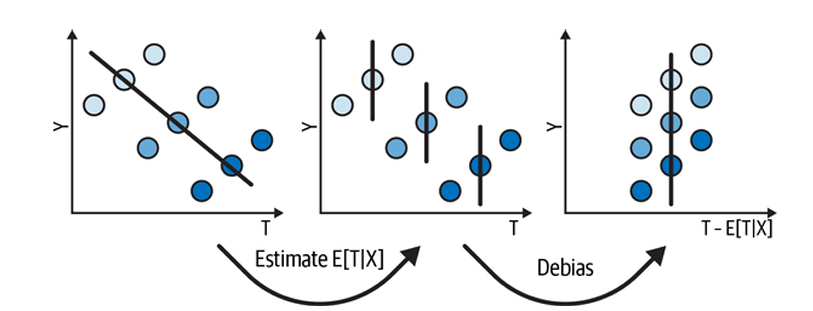

</center>

따라서 잡음을 제거하기 다시 회귀모델을 사용하여 $E[Y|X]$를 추정하고 잡음이 제거된 결과인 $Y-E[Y|X]$를 만든다. 잡음이 제거된 결과를 $X$에 의해 설명된 모든 분산을 고려한 후의 결과라고 볼 수 있다. $X$가 $Y$의 분산을 많이 설명하면 잡음이 줄어들어, 실제로 관심있는 $T$와 $Y$ 사이의 관계를 더 쉽게 파악할 수 있다.

<center>

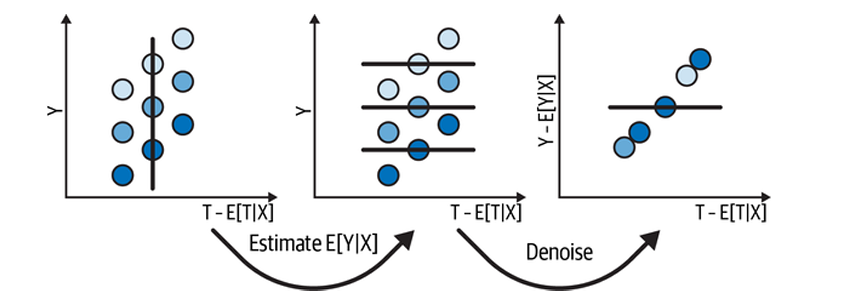

</center>

마지막으로 편향, 잡음을 제거하여 $T$와 $Y$ 사이의 관계를 명확하게 볼 수 있다. 이제 이 데이터에 최종 모델을 적합시키면 된다. 마지막 회귀식은 $Y$를 $T$와 $X$에 동시에 회귀했을 때의 기울기와 정확히 같다.

---

## 4.4 결과 모델로서의 회귀분석

회귀분석은 처치를 직교화하는 방식이면서도, **우리가 알 수 없는 잠재적 결과를 대체(Imputation)** 하는 방법으로도 볼 수 있다.

처치가 0 또는 1의 이진 값으로 주어진다고 가정하자. 대조군($T=0$)에서 $X$에 대한 $Y$의 회귀모델이 $E[Y_0|X]$를 잘 추정한다면 해당 모델을 사용해 $Y_0$를 대체하고 $ATT$를 추정할 수 있다.
$$
ATT=\frac{1}{N_1}\sum I(T_i=1)(Y_i-\hat{\mu_0}(X_i))
$$

$I(\cdot)$은 지시 함수이며, $N_1$은 실험군 대상자의 수이다.

마찬가지로, 실험군($T=1$)에서 $X$에 대한 $Y$의 회귀모델이 $E[Y_1|X]$를 잘 모델링하면 이를 이용해서 대조군에서 평균 효과를 추정할 수 있다. 두 접근법을 병행하면 다음과 같이 $ATE$를 추정할 수 있다.
$$
ATE=\frac{1}{N}\sum(\hat{\mu_1}(X_i)-\hat{\mu_0}(X_i))
$$

이 추정량은 모든 실험 대상의 두 가지 잠재적 결과 모두를 대체한다. $Y$를 $X$와 $T$로 회귀식을 만들어 $T$에 대한 파라미터 추정값을 얻는 것과 동일하다.

또한 누락된 잠재적 결과를 대체할 수도 있다.
$$
ATE = \frac{1}{N}\sum[I(T_i=1)(Y_i-\hat{\mu_0}(X_i))+I(T_i=0)(\hat{\mu_1}(X_i)-Y_i)]

$T$가 연속형이면 개념화하기 조금 어렵지만, 회귀분석은 전체 처치 반응 변수를 대체하는 것으로 이해할 수 있다. 여기에는 잠재적 결과 $Y(t)$를 선처럼 대체하는 것이 포함된다.

$E[T|X]$를 정확하게 추정하여 직교화할 수 있거나 잠재적 결과 $E[Y_t|X]$를 정확하게 추정할 수 있다는 사실은 앞으로 사용되는 방법에서 중요하게 다룬다.

---

## 4.5 양수성과 외삽

회귀분석은 잠재적 결과를 모수적(parametric)으로 모델링하므로 데이터의 처치 범위 이외에 대해서도 외삽을 할 수 있다. 외삽이란, 관측된 데이터 범위를 벗어나서 예측하거나 추론을 하는 것을 말한다.외삽이 합리적인지에 따라, 유용하게 사용될 수도 있고 역효과를 불러올 수도 있다.

예를 들어 중첩(*overlap*: 모든 $x$ 구간에 대해 실험군과 대조군이 모두 존재하는지 여부)이 적은 데이터셋에서 처치효과를 추정해야 한다고 가정해보자. 이를 데이터셋 1이라고 한다. 데이터셋 1에서 공변량 $x$값이 클 때는 대조군이 존재하지 않고, 반대로 작을 때는 실험군이 없다. 이 데이터에 회귀분석을 사용하여 처치효과를 추정하면 왼쪽 그래프의 선과 같이 $Y_0$와 $Y_1$을 추정한다.

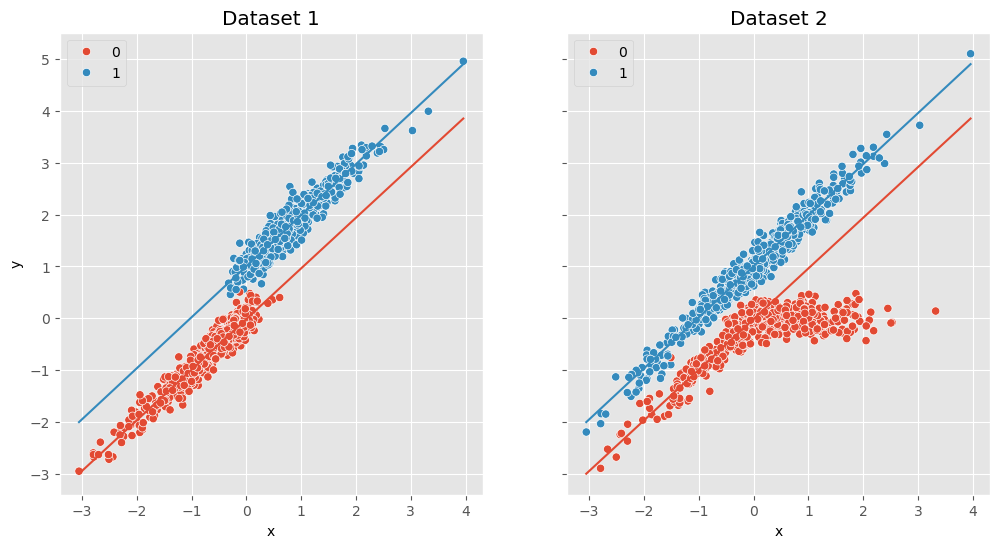

In [75]:
np.random.seed(1)

n = 1000
x = np.random.normal(0, 1, n)
t = np.random.normal(x, 0.2, n) > 0

y0 = x 
y1 = 1 + x
y = np.random.normal((1-t)*y0 + t*y1, 0.2)
df_no_pos = pd.DataFrame(dict(x=x,t=t.astype(int),y=y))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
sns.scatterplot(data=df_no_pos, x="x", y="y", hue="t", ax=ax1)

m0 = smf.ols("y~x", data=df_no_pos.query(f"t==0")).fit()
m1 = smf.ols("y~x", data=df_no_pos.query(f"t==1")).fit()

sns.lineplot(data=df_no_pos.assign(pred=m0.predict(df_no_pos)), x="x", y="pred", color=f"C0", ax=ax1)
sns.lineplot(data=df_no_pos.assign(pred=m1.predict(df_no_pos)), x="x", y="pred", color=f"C1", ax=ax1);
ax1.set_title("Dataset 1")

np.random.seed(1)

n = 1000
x = np.random.normal(0, 1, n)
t = np.random.binomial(1, 0.5, size=n)

y0 = x * (x<0) + (x>0)*0
y1 = 1 + x
y = np.random.normal((1-t)*y0 + t*y1, 0.2)
df_pos = pd.DataFrame(dict(x=x,t=t.astype(int),y=y))

sns.scatterplot(data=df_pos, x="x", hue="t", y="y", ax=ax2)
sns.lineplot(data=df_no_pos.assign(pred=m0.predict(df_pos)), x="x", y="pred", color=f"C0", ax=ax2)
sns.lineplot(data=df_no_pos.assign(pred=m1.predict(df_pos)), x="x", y="pred", color=f"C1", ax=ax2)
ax2.set_title("Dataset 2")

plt.show()

왼쪽 그래프를 보면 추세가 비슷한 경향을 보인다. $x$가 작을 때 대조군에 적합시킨 $Y_0$와 $x$ 간의 관계가 $x$가 클 때도 유효하고, 실험군에 적합시킨 $Y_1$이 $x$가 작을 때도 잘 외삽할 수 있다면 문제가 되지 않는다. 즉, 공변량 공간 전반에 중첩이 있는 결과 추세선이 비슷하면 약간의 외삽은 문제가 되지 않는다.

하지만 지나친 외삽은 위험하다. 데이터셋 1에서 효과를 추정했지만 더 많은 데이터를 수집하여 처치를 무작위로 배정했다고 가정해본다. 새로운 데이터인 데이터셋 2에서는 $x$가 양수일 때 대조군과 실험군의 차이가 커진다. 즉, **처치효과의 차이가 점점 커지는 것을 볼 수 있다.** 따라서 전에 적합시킨 모델을 데이터셋 2에 사용하면 실제 처치효과보다 크게 과소평가될 것이다.

이는 양수성 가정이 충족되지 않은 영역, 즉 **특정 처치를 전혀 받지 않은 확률이 있는 범위에서의 처치효과는 정확히 알 수 없다는 것을 보여준다.** 이러한 범위에 대한 외삽을 신뢰할 수도 있지만 이에 따른 위험도 감수해야 한다.

요약하자면, 양수성 가정이 충족되지 않을 경우 회귀분석은 외삽을 통해 해당 가정이 충족되지 않는 영역을 대체하게 된다.

---

## 4.6 선형회귀에서의 비선형성

실제 데이터에서는 **선형적이지 않은 상황을 마주할 가능성이 높다.** 예를 들어, 이전과 동일한 데이터로 신용한도가 신용카드 소비에 미치는 인과효과를 추정해본다.

In [76]:
spend_url='https://raw.githubusercontent.com/matheusfacure/causal-inference-in-python-code/main/causal-inference-in-python/data/spend_data.csv'

spend_data=pd.read_csv(spend_url)
spend_data.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,spend
0,950.0,11,16,1,500.0,518.0,3200.0,3848
1,780.0,11,7,1,414.0,429.0,1700.0,3144
2,1230.0,14,9,1,586.0,571.0,4200.0,4486
3,1040.0,15,8,1,379.0,411.0,1500.0,3327
4,1000.0,16,1,1,379.0,518.0,1800.0,3508


유일한 교란요인이 임금이라고 가정해본다(은행에서 신용한도를 정할 때, 유일하게 임금정보만 사용한다는 뜻이다). 이때 인과 그래프는 다음과 같다.

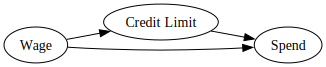

In [77]:
g_risk = gr.Digraph(graph_attr={"rankdir":"LR"})

g_risk.edge("Wage", "Credit Limit")
g_risk.edge("Wage", "Spend")
g_risk.edge("Credit Limit", "Spend")

g_risk

따라서 신용 한도가 소비에 미치는 영향을 파악하려면 임금을 통제해야 한다. 효과 추정에 직교화를 사용하고 싶다면, 신용 한도를 임금을 사용해 회귀식을 만들어 잔차를 구해 신용 한도의 편향을 제거해야 한다.
$$
\widehat{CreditLim} = \theta_0+\theta_1Wage
$$

$$
\widetilde{CreditLim} = CreditLim-\widehat{CreditLim}
$$

여기서 한가지 문제점이 생긴다. 여러 임금 수준에서 신용한도별 소비 그래프를 보면, 두 변수 사이의 관계는 **비선형적**이다.

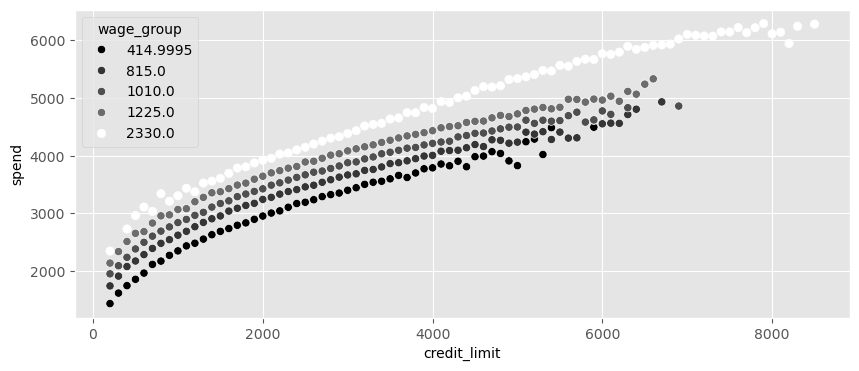

In [78]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit"])
          [["spend"]]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df, 
                x="credit_limit",
                y="spend",
                hue="wage_group",
                palette="gray")

plt.show()

물론, 선형적인 관계로 사용해도 어느 정도 추세를 비슷하게 추정할 수 있지만, 로그 함수의 형태처럼 신용한도가 높을수로 곡선의 기울기가 줄어드는 것을 볼 수 있다. 기울기와 인과효과는 밀접한 관련이 있으므로, 인과추론 관점에서 신용한도가 증가함에 따라 한도가 소비에 미치는 효과는 조금씩 감소한다고 볼 수 있다.

### 처치 선형화

이 문제를 해결하려면 먼저 처치를 결과와 선형 관계로 변환해야 한다. 로그함수,제곱근 함수 또는 분수의 거듭제곱 등이 좋은 후보가 될 수 있다. 여기서는 제곱근을 사용해본다.

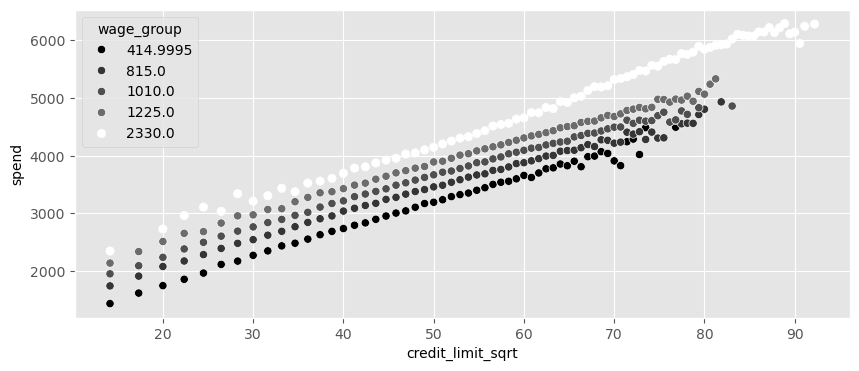

In [79]:
plt_df = (spend_data
          # 처치그룹에 제곱근 함수 np.sqrt() 적용
          .assign(credit_limit_sqrt = np.sqrt(spend_data["credit_limit"]))
          # 5개의 그룹을 만들어 시각화
          .assign(wage_group = pd.IntervalIndex(pd.qcut(spend_data["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit_sqrt"])
          [["spend"]]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df, 
                x="credit_limit_sqrt",
                y="spend",
                palette="gray",
                hue="wage_group")

plt.show()

신용 한도의 제곱근은 소비와 선형 관계가 있는 것 같다. 자세히 보면 곡선이 약간 남아 있지만, 그래도 괜찮아 보인다.

이 과정에서 어떤 변환을 적용해야하는지는 직접 시도해봐야 한다. 가장 좋은 변환을 찾으면 해당 함수를 적용한 선형회귀모델을 실행할 수 있다. 이번 예시에서는 다음과 같은 모델을 추정하게 된다.
$$
spend_i = \beta_0+\beta_1 \sqrt{CreditLim_i}+e_i
$$

찾고 싶은 인과 파라미터는 $\beta_1$이다.

이 모델을 `statsmodels`에 넘파이 제곱근 함수를 공식에 사용하여 추정할 수 있다.

In [80]:
model_spend = smf.ols(
    'spend~np.sqrt(credit_limit)',data=spend_data
).fit()

model_spend.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,493.0044,6.501,75.832,0.000,480.262,505.747
np.sqrt(credit_limit),63.2525,0.122,519.268,0.000,63.014,63.491


이 예시에서는 임금이 신용한도와 소비 사이에서 교란요인으로 작용하고 있다. 이전 모델의 예측값과 원본 데이터를 그래프에 나타내보면, 기울기가 상향 편향되어 있음을 알 수 있다. 임금이 높아지면 소비와 신용한도 모두 증가하기 때문이다.

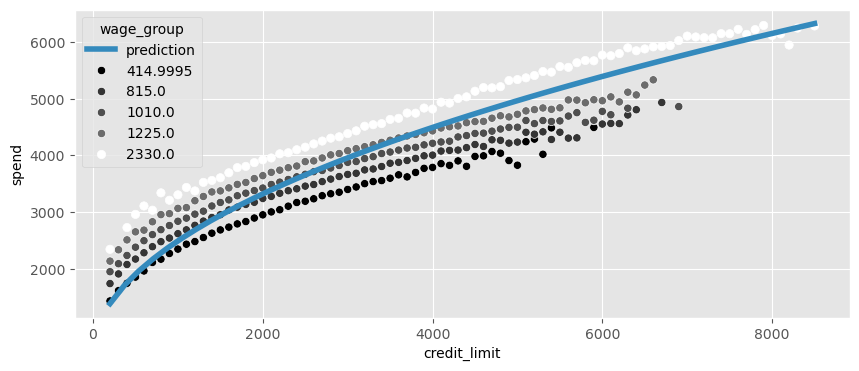

In [81]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit"])
          [["spend"]]
          .mean()
          .reset_index()
         )

x = np.linspace(plt_df["credit_limit"].min(), plt_df["credit_limit"].max())

plt.figure(figsize=(10,4))
plt.plot(x, model_spend.params[0] + model_spend.params[1]*np.sqrt(x), color="C1", label="prediction", lw=4)
plt.legend()
sns.scatterplot(data=plt_df, 
                x="credit_limit",
                y="spend",
                palette="gray",
                hue="wage_group")
plt.show()

모델에 임금을 포함하면 다음과 같다.
$$
spend_i = \beta_0+\beta_1\sqrt{CreditLim_i}+\beta_2wage_i+e_i
$$

다시 $\beta_1$을 추정하면 신용한도가 소비에 미치는 영향의 편향되지 않은 추정값을 얻을 수 있다. 이 추정값은 앞서 얻은 값보다 작다. 모델에 임금을 포함해서 상향 편향을 보정했기 때문이다.

In [82]:
model_spend = smf.ols('spend~np.sqrt(credit_limit)+wage',
                      data=spend_data).fit()

model_spend.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,383.5002,2.746,139.662,0.000,378.118,388.882
np.sqrt(credit_limit),43.8504,0.065,672.633,0.000,43.723,43.978
wage,1.0459,0.002,481.875,0.000,1.042,1.050


### 비선형 FWL과 편향 제거

비선형 데이터에 *FWL* 정리를 적용하는 방법은 기본적인 *FWL*과 동일하지만, 먼저 비선형 처리를 해야 한다. 선형회귀를 이용해 비선형모델을 추정하는 과정은 다음과 같다.

- 1. **처치 선형화 단계** : $T$와 $Y$의 관계를 선형화하는 함수 $F$를 찾는다.  

- 2. **편향 제거 단계** : $F(T)$를 교란 요인 $X$로 회귀식을 만들고 처치 잔차 $\widetilde{F(T)}=F(T)-\widehat{F(T)}$를 구한다.  

- 3. **잡음 제거 단계** : 결과 $Y$를 교란 요인 $X$로 회귀식을 만들고 결과 잔차 $\tilde{Y}=Y-\hat{Y}$을 구한다.  

- 4. **결과 모델 단계** : 이렇게 얻은 결과 모델은 결과 잔차 $\tilde{Y}$를 처치 잔차 $\widetilde{F(T)}$로 회귀식을 만들어 $F(T)$가 $Y$에 미치는 인과효과의 추정값을 구한다.

다음은 이를 구현한 코드이다. 시각화를 위해 $\overline{F(CreditLim)}$와 $\overline{spend}$를 추가했다.

In [83]:
## 편향 제거
debiased_spend_model = smf.ols(f'np.sqrt(credit_limit)~wage',
                               data=spend_data).fit()

credit_limit_sqrt_deb = (debiased_spend_model.resid
                         + np.sqrt(spend_data['credit_limit']).mean())

## 잡음 제거
denoised_spend_model = smf.ols(f'spend~wage',data=spend_data).fit()

spend_den = denoised_spend_model.resid + spend_data['spend'].mean()

## 결과 모델 단계
spend_data_deb = (spend_data.assign(credit_limit_sqrt_deb=credit_limit_sqrt_deb,
                                    spend_den = spend_den))
final_model = smf.ols(f'spend_den ~ credit_limit_sqrt_deb',
                      data=spend_data_deb).fit()

final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1493.6990,3.435,434.818,0.000,1486.966,1500.432
credit_limit_sqrt_deb,43.8504,0.065,672.640,0.000,43.723,43.978


여기서 얻은 $\beta_1$ 추정값은 앞서 교란요인인 임금과 처치를 모두 포함한 완전모델을 실행하여 얻은 추정값과 완전히 동일하다. 또한 이 모델의 예측값을 원본 데이터와 비교해 그려보면, 이전처럼 상향 편향되지 않고 임금 그룹의 중간을 통과한다.

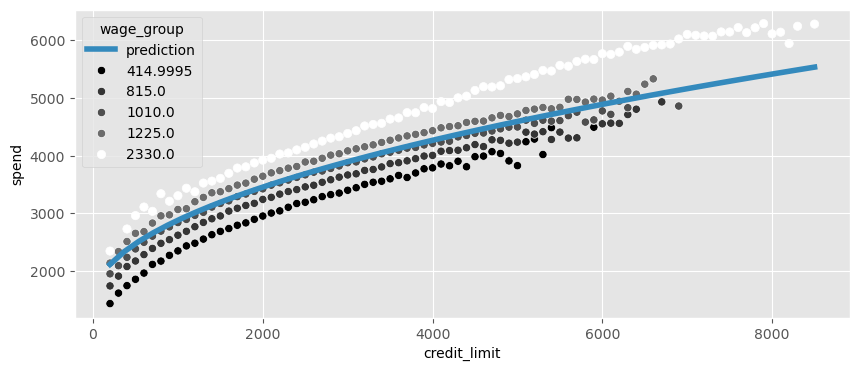

In [84]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit"])
          [["spend"]]
          .mean()
          .reset_index())

x = np.linspace(plt_df["credit_limit"].min(), plt_df["credit_limit"].max())

plt.figure(figsize=(10,4))
plt.plot(x, (final_model.params[0] 
             + final_model.params[1]*np.sqrt(x)),
         color="C1", label="prediction", lw=4)

plt.legend()

sns.scatterplot(data=plt_df, 
                x="credit_limit",
                y="spend",
                palette="gray",
                hue="wage_group")
plt.show()

---

## 4.7 더미변수를 활용한 회귀분석

회귀분석과 직교화는 우수한 도구이지만, 결국 **독립성 가정**이 필요하다. 일부 공변량을 통제했을 때 처치가 무작위로 배정되는 것처럼 보이도록 가정해야 하지만, 이는 쉽지 않다.

모델에 모든 교란요인이 포함되는지를 판단하기는 어렵기 때문에 가능하면 무작위 실험을 실시하는 편이 좋다. 하지만 무작위 통제 실험에는 큰 비용과 2장에서 언급했던 것처럼 윤리적인 문제가 발생할 수 있다. 신용한도 예시에서, 신용한도를 랜덤으로 배정했다가 상환 능력이 없는 고객에게 높은 신용한도를 배정하면 그 은행은 큰 재무적인 손실이 발생할 것이다.

### 조건부 무작위 실험

이를 해결하는 방법으로, 이상적인 무작위 통제 실험 대신 차선책인 **조건부 무작위 실험**을 사용하는 것이다(계층화 무작위 실험이라고도 한다). 모든 고객에게 동일한 확률 분포에서 완전 무작위로 신용 한도를 설정하는 실험을 설계하는 대신, 고객 공변량에 따라 서로 다른 분포에서 표본을 뽑아 여러 국소 실험을 만든다.

예를 들어, `credit_score1` 변수가 고객 위험도의 대리변수임을 알고 있으므로 이 변수를 사용하여 위험도에 따른 고객 그룹을 생성할 수 있다. `credit_score1`이 비슷한 고객들을 묶는 것이다. 그리고 `credit_score1`이 낮은 고위험 그룹은 평균이 낮은 분포에서 신용 한도를 추출하여 무작위로 배정하고, 높은 저위험 고객은 평균이 높은 분포에서 추출하여 신용한도를 무작위로 배정한다.

In [85]:
risk_rnd_url='https://raw.githubusercontent.com/matheusfacure/causal-inference-in-python-code/main/causal-inference-in-python/data/risk_data_rnd.csv'

risk_rnd_data=pd.read_csv(risk_rnd_url)
risk_rnd_data.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_score1_buckets,credit_limit,default
0,890.0,11,16,1,490.0,500.0,400,5400.0,0
1,670.0,11,7,1,196.0,481.0,200,3800.0,0
2,1220.0,14,9,1,392.0,611.0,400,5800.0,0
3,1210.0,15,8,1,627.0,519.0,600,6500.0,0
4,900.0,16,1,1,275.0,519.0,200,2100.0,0


신용한도의 히스토그램을 `credit_score1_buckets` 별로 표시하면 신용한도가 서로 다른 분포에서 추출되었음을 알 수 있다.

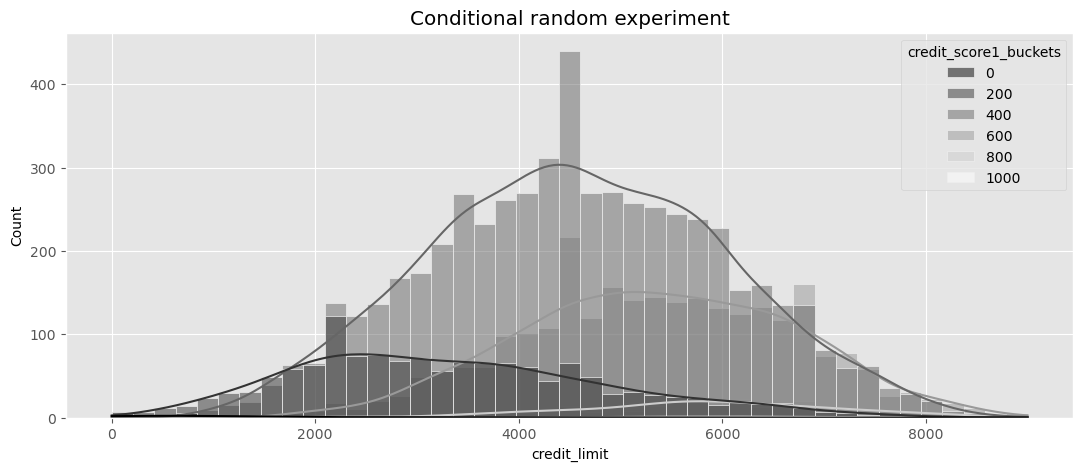

In [86]:
plt.figure(figsize=(13,5))
sns.histplot(data=risk_rnd_data,
             x="credit_limit",
             hue="credit_score1_buckets",
             kde=True,
             palette="gray");
plt.title("Conditional random experiment")
plt.show()

점수가 높은 고객(저위험 고객) 그룹은 히스토그램이 오른쪽으로 치우치며 더 높은 신용한도를 나타낸다. 반대로 더 위험한 고객(점수가 낮은 고객) 그룹은 왼쪽으로 치우치며 신용한도가 더 낮다. 이러한 실험은 최적의 신용한도에서 크게 벗어나지 않으면서 실험비용을 관리할 수 있는 수준으로 낮춘다.

조건부 무작위 실험은 완전 무작위 실험보다 비용이 저렴하지만 더 복잡하다. 따라서 어떤 이유로든 조건부 무작위 실험을 선택한다면, 가능한 한 완전 무작위 실험에 가깝게 설계해야 한다.  
- 그룹 수가 적을수록 조건부 무작위 실험을 진행하기가 더 쉬워진다. 이 예에서는 0~1000 사이 범위에 있는 `credit_score1`을 200 단위로 나누어 그룹이 5개만 있다. 처치 분포가 서로 다른 여러 그룹을 결합하면 복잡해지므로 적은 수의 그룹을 유지하는 편이 좋다.  

- 그룹 간 처치 분포가 많이 중첩될수록 분석이 용이해진다. 이는 양수성 가정과 관련이 있다. 이 사례에서 고위험 그룹이 높은 신용한도를 받을 확률이 0인 경우, 고위험 그룹이 높은 신용한도를 받게 된다면 어떤 일이 발생할지 알기 위해 외삽에 의존해야 한다.

이 두 가지 경험적 규칙을 최대한 적용하면 완전 무작위 실험으로 돌아가게 된다. 이는 위의 규칙 모두에 **트레이드오프**가 있음을 의미한다. 즉, 그룹 수가 적고 겹치는 부분이 많을수록 실험 결과 해석이 쉽지만 더 큰 비용이 든다. 그 반대도 마찬가지이다.

### 더미변수

조건부 무작위 실험의 장점은 설정한 범주형 변수에 따라 신용한도가 무작위로 배정되었음을 알기 때문에, 조건부 독립 가정에 훨씬 더 설득력이 생긴다. 하지만 실험군에 대한 결과만으로 단순 회귀분석을 하면 편향된 추정값을 얻게 된다는 단점이 있다.

예를 들어, 교란요인을 포함하지 않고 모델을 추정하면 결과는 다음과 같다.
$$
default_i = \beta_0+\beta_1 CreditLim_i+e_i
$$

In [87]:
model = smf.ols('default ~ credit_limit',data=risk_rnd_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1369,0.009,15.081,0.000,0.119,0.155
credit_limit,-9.344e-06,1.85e-06,-5.048,0.000,-1.3e-05,-5.72e-06


보다시피 인과 매개변수 추정값이 $\hat{\beta_1}$은 음수이다. 더 높은 신용한도가 고객의 채무불이행 위험을 낮추지는 않으므로 추정값이 음수인 것은 말이 되지 않는다. 이러한 결과가 나온 이유는 실험이 설계된 방식으로 인해 위험도가 낮은 고객(`credit_score1`이 높은 고객)이 평균적으로 더 높은 한도를 받았기 때문이다.

이를 보정하려면 모델에 처치가 무작위로 배정된 그룹 정보를 포함해야 한다. 여기서는 `credit_score1_buckets`를 통제해야 한다. 이 그룹이 숫자로 표현되지만 실제로는 범주형 변수이다. 따라서 그룹 자체를 통제하는 방법은 **더미변수(가변수)** 를 만드는 것이다. 더미변수는 그룹에 대해 이진값으로 구성된 열이다. 즉, 고객이 해당 그룹에 속하면 1이고 그렇지 않으면 0이다. 고객은 하나의 그룹에만 속할 수 있으므로 더미 열 중에서 오직 하나만 1의 값을 갖고 나며지 열은 모두 0이 된다. 머신러닝에서의 *One-hot encoding*과 같은 개념이다.

판다스에서 `pd.get_dummies` 함수를 사용하여 더미변수를 만들 수 있다. 다음 코드는 그룹을 나타내는 열인 `credit_score1_buckets`를 전달하고 `sb`(score bucket의 줄임말)가 붙은 더미 열을 만드는 과정을 보여준다.

In [ ]:
risk_data_dummies = (
    risk_rnd_data.join(pd.get_dummies(risk_rnd_data['credit_score1_buckets'],
                                      prefix='sb',
                                      drop_first=True))
)

In [90]:
risk_data_dummies.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_score1_buckets,credit_limit,default,sb_200,sb_400,sb_600,sb_800,sb_1000
0,890.0,11,16,1,490.0,500.0,400,5400.0,0,0,1,0,0,0
1,670.0,11,7,1,196.0,481.0,200,3800.0,0,1,0,0,0,0
2,1220.0,14,9,1,392.0,611.0,400,5800.0,0,0,1,0,0,0
3,1210.0,15,8,1,627.0,519.0,600,6500.0,0,0,0,1,0,0
4,900.0,16,1,1,275.0,519.0,200,2100.0,0,1,0,0,0,0


이제 모델에 더미 열을 추가하고 $\beta_1$을 다시 추정해본다.
$$
default_i=\beta_0+\beta_1 CreditLim_i + \theta G_i+e_i
$$

In [92]:
model = smf.ols(
    'default ~ credit_limit + sb_200 + sb_400 + sb_600 + sb_800 + sb_1000',
    data = risk_data_dummies).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2253,0.056,4.000,0.000,0.115,0.336
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.97e-07,8.61e-06
sb_200,-0.0559,0.057,-0.981,0.327,-0.168,0.056
sb_400,-0.1442,0.057,-2.538,0.011,-0.256,-0.033
sb_600,-0.2148,0.057,-3.756,0.000,-0.327,-0.103
sb_800,-0.2489,0.060,-4.181,0.000,-0.366,-0.132
sb_1000,-0.2541,0.094,-2.715,0.007,-0.438,-0.071


이제 훨씬 타당한 추정값을 얻었다. 이 추정값은 양수이며, 신용 한도가 높을수록 채무불이행 위험이 높아지는 것을 알 수 있다.

파이썬에서 `statsmodels`를 사용할 때는 `C()` 함수를 넣어 더미변수를 만들 수도 있다.

In [93]:
model = smf.ols('default ~ credit_limit + C(credit_score1_buckets)',
                data = risk_rnd_data).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2253,0.056,4.000,0.000,0.115,0.336
C(credit_score1_buckets)[T.200],-0.0559,0.057,-0.981,0.327,-0.168,0.056
C(credit_score1_buckets)[T.400],-0.1442,0.057,-2.538,0.011,-0.256,-0.033
C(credit_score1_buckets)[T.600],-0.2148,0.057,-3.756,0.000,-0.327,-0.103
C(credit_score1_buckets)[T.800],-0.2489,0.060,-4.181,0.000,-0.366,-0.132
C(credit_score1_buckets)[T.1000],-0.2541,0.094,-2.715,0.007,-0.438,-0.071
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.97e-07,8.61e-06


여기서는 기울기 파라미터가 하나뿐이다. 교란요인을 통제하려고 더미변수를 추가하면 그룹당 하나의 절편이 생기지만 모든 그룹에 동일한 기울기가 적용된다. 해당 기울기는 각 그룹의 회귀에 대한 분산 가중평균이 된다. 각 그룹에 대한 모델의 예측 결과를 시각화하면 그룹별로 하나의 선이 있으며 모든 선의 기울기가 동일한 것을 알 수 있다.

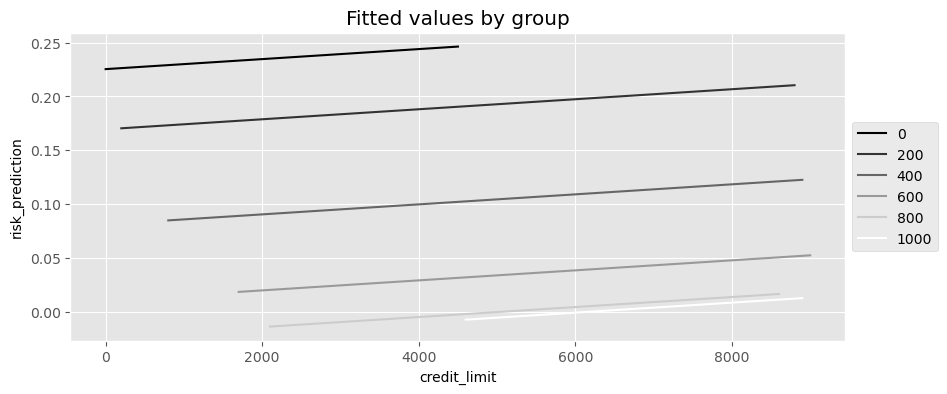

In [96]:
plt_df = (risk_rnd_data
          .assign(risk_prediction = model.fittedvalues)
          .groupby(["credit_limit", "credit_score1_buckets"])
          ["risk_prediction"]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.lineplot(data=plt_df,
             x="credit_limit", y="risk_prediction", hue="credit_score1_buckets", palette = 'gray');
plt.title("Fitted values by group")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### 포화회귀모델

이진 처치에 대한 회귀분석은 실험군과 대조군의 평균을 비교하는 것과 같다. 더미변수는 이진값이므로 같은 논리가 여기에도 적용된다.

In [100]:
def regress(df,t,y):
    return smf.ols(f'{y}~{t}',data=df).fit().params[t]

effect_by_group = (risk_rnd_data.groupby('credit_score1_buckets').apply(regress,y='default',t='credit_limit'))
effect_by_group

credit_score1_buckets
0      -0.000071
200     0.000007
400     0.000005
600     0.000003
800     0.000002
1000    0.000000
dtype: float64

회귀분석이 익숙하지 않다면 첫 시도로 조건부 무작위 실험 데이터를 `credit_score1_buckets`에 따라 나누고 그룹별로 효과를 추정할 것이다. 이 방법을 통해 그룹별 효과를 알 수 있으나, 평균을 어떻게 구할지에 대한 결정이 필요하다.

가장 자연스러운 선택으로, 각 그룹의 크기를 가중치로 삼아 가중평균을 취하는 것으로 생각할 수 있다.

In [101]:
group_size = risk_rnd_data.groupby('credit_score1_buckets').size()
ATE = (effect_by_group * group_size).sum() / group_size.sum()
ATE

4.4904456287487205e-06

회귀분석에서도 똑같은 작업을 수행할 수 있다. **포화모델(Full-model)** 을 사용하면 된다. 포화모델은 회귀분석에서 모든 가능한 설명변수와 그 교호작용을 포함하는 모델을 말한다. 이 모델은 주어진 데이터에 대해 모든 변수와 상호작용을 포함하므로 과적합 위험이 있고 일반화 능력이 떨어지지만, 특정 그룹의 인과효과를 파악하는데 유용하게 사용된다.

더미변수와 처치에 대한 교호작용 항에서, 각 더미변수에 해당하는 그룹의 인과효과를 추정하면 된다. 첫 번째 더미변수는 제외했으므로 `credit_limit`과 관련된 파라미터는 생략된 더미 그룹 `sb_100`의 효과를 나타낸다.

In [102]:
model = smf.ols('default~credit_limit*C(credit_score1_buckets)',
                data=risk_rnd_data).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3137,0.077,4.086,0.000,0.163,0.464
C(credit_score1_buckets)[T.200],-0.1521,0.079,-1.926,0.054,-0.307,0.003
C(credit_score1_buckets)[T.400],-0.2339,0.078,-3.005,0.003,-0.386,-0.081
C(credit_score1_buckets)[T.600],-0.2957,0.080,-3.690,0.000,-0.453,-0.139
C(credit_score1_buckets)[T.800],-0.3227,0.111,-2.919,0.004,-0.539,-0.106
C(credit_score1_buckets)[T.1000],-0.3137,0.428,-0.733,0.464,-1.153,0.525
credit_limit,-7.072e-05,4.45e-05,-1.588,0.112,-0.000,1.66e-05
credit_limit:C(credit_score1_buckets)[T.200],7.769e-05,4.48e-05,1.734,0.083,-1.01e-05,0.000
credit_limit:C(credit_score1_buckets)[T.400],7.565e-05,4.46e-05,1.696,0.090,-1.18e-05,0.000
credit_limit:C(credit_score1_buckets)[T.600],7.398e-05,4.47e-05,1.655,0.098,-1.37e-05,0.000


교호작용 파라미터는 생략된 첫 번째 그룹의 효과와 연관지어 해석해야 한다. 따라서 `credit_limit`과 관련된 파라미터와 교호작용 항을 더하면 회귀분석을 사용해 그룹별로 추정된 효과를 얻을 수 있다. 이는 **그룹별로 하나의 효과를 각각 추정할 때와 결과가 동일**하다.

In [104]:
(model.params[model.params.index.str.contains('credit_limit:')]
 + model.params['credit_limit']).round(9)

credit_limit:C(credit_score1_buckets)[T.200]     0.000007
credit_limit:C(credit_score1_buckets)[T.400]     0.000005
credit_limit:C(credit_score1_buckets)[T.600]     0.000003
credit_limit:C(credit_score1_buckets)[T.800]     0.000002
credit_limit:C(credit_score1_buckets)[T.1000]    0.000000
dtype: float64

해당 모델의 그룹별 예측값을 시각화해본다.

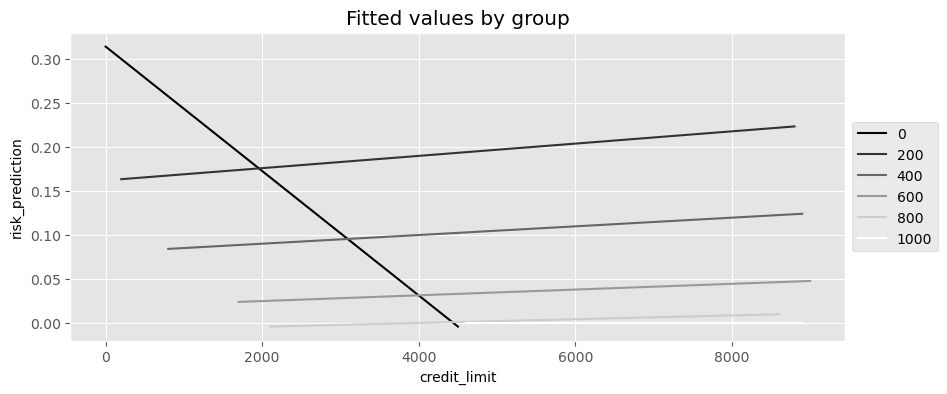

In [106]:
plt_df = (risk_rnd_data
          .assign(risk_prediction = model.fittedvalues)
          .groupby(["credit_limit", "credit_score1_buckets"])
          ["risk_prediction"]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.lineplot(data=plt_df,
             x="credit_limit", y="risk_prediction", hue="credit_score1_buckets",  palette="gray");
plt.title("Fitted values by group")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

그룹마다 별도의 회귀모델을 적합시킨 것처럼 보인다. 각각 절편 뿐만 아니라 기울기도 다르다. 포화모델은 파라미터(자유도)가 더 많으며, 이는 다른 모든 조건이 동일한 때 분산이 더 큼을 의미한다. 또한 위의 그래프에서 맥락과 맞지 않는 기울기가 음인 선이 나타난다. 이 기울기는 통계적으로 유의하지 않으며, 해당 그룹의 작은 표본 크기 때문에 발생한 잡음일 가능성이 높다.

### 분산의 가중평균과 회귀분석

교호작용 항 없이 `default ~ credit_limit + C(credit_score1_buckets)` 모델을 실행하면 단일 효과, 즉 하나의 파라미터만 얻게 된다. 이 추정값은 그룹별 효과를 추정하고 그룹 크기를 가중치로 사용하여 평균한 결과와 다르다는 점이 중요하다.  
즉, 회귀분석은 여러 그룹의 효과를 합친 것이지만, 표본 크기를 기준으로 한 가중평균은 아니다.

시뮬레이션 데이터를 사용하여 논의해본다. 두 개의 다른 그룹에서 데이터를 시뮬레이션을 실시한다. 첫 번째 그룹은 크기가 1000이며 평균 처치효과가 1이다. 두 번째 그룹은 크기가 500이고 평균 처치효과가 2이다. 두 그룹의 처치효과의 표준편차는 각각 1과 2이다.

In [108]:
np.random.seed(123)

# 그룹 1
t1 = np.random.normal(0,1,size=1000)
df1 = pd.DataFrame(dict(
    t=t1,
    y=1*t1,  ## ATE = 1
    g=1
))

##그룹 2
t2 = np.random.normal(0,2,size=500)
df2 = pd.DataFrame(dict(
    t=t2,
    y=2*t2,  ## ATE = 2
    g=2
))

df = pd.concat([df1,df2])
df.head()

,t,y,g
0,-1.085631,-1.085631,1
1,0.997345,0.997345,1
2,0.282978,0.282978,1
3,-1.506295,-1.506295,1
4,-0.578600,-0.578600,1


그룹별 효과를 각각 추정하고 그룹 크기를 가중치로 사용한 평균 결과인 $ATE$는 약 1.33이다.

In [109]:
effect_by_group = df.groupby('g').apply(regress,y='y',t='t')
ATE = (effect_by_group * 
       df.groupby('g').size()).sum() / df.groupby('g').size().sum()

ATE

1.333333333333333

그러나 그룹을 통제하면서 $y$를 $t$를 사용하여 회귀식을 만들면 매우 다른 결과가 나타난다. 그룹 2의 표본이 그룹 1의 절반임에도 불구하고 결합한 효과는 그룹 2의 효과에 더 가깝다.

In [110]:
model = smf.ols('y~t+C(g)',data=df).fit()
model.params

Intercept    0.024758
C(g)[T.2]    0.019860
t            1.625775
dtype: float64

이는 회귀분석이 그룹 효과를 결합할 때 표본 크기를 가중치로 사용하지 않고, **각 그룹에서 처치의 분산에 비례하는 가중치를 사용**한다. 회귀분석은 처치 변동성이 큰 그룹을 선호한다. 한 그룹 내에서 처치가 많이 변할수록 결과에 미치는 영향이 더 분명해진다.

여러 그룹이 있고, 각 그룹 내에서 처치가 무작위 배정된 경우, 조건부 원칙에 따르면 효과는 각 그룹 내 효과의 가중평균이다.
$$
ATE=E\left\{ (\frac{\partial }{\partial t}E\left[ Y_i\ | T=t,Group_i \right]w(Group_i) \right\}
$$

사용하는 방법에 따라 다른 가중치를 적용할 수 있다. 회귀분석에서는 $w(Group_i)\propto \sigma^2(T)|Group$를 사용하지만, $w(Group_i)=N_{Group}$처럼 표본 크기를 가중치로 사용하여 그룹 효과에 직접 가중치를 부여할 수도 있다.

### 평균 제거와 고정효과

*FWL* 정리는 더미변수가 있는 상황에서 더욱 효과적이다. 그룹이 많을 때, 각 그룹에 더미를 추가하려면 번거롭고 연산과정이 복잡하다. 그리고 대부분 0인 많은 열을 생성하게 된다. 이 문제는 더미변수에 대해 *FWL* 정리를 적용하고 회귀분석이 처치를 직교화하는 방법을 이해하면 더 쉽게 해결할 수 있다.

*FWL* 정리에서 편향 제거 단계는 공변량에서 처치를 예측하는 과정을 포함한다. 여기서 공변량이 더미변수이다.

In [ ]:
##편향 제거 단계 과정
model_deb = smf.ols('credit_limit~C(credit_score1_buckets)',
                    data=risk_rnd_data).fit()
model_deb.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1173.0769,278.994,4.205,0.000,626.193,1719.961
C(credit_score1_buckets)[T.200],2195.4337,281.554,7.798,0.000,1643.530,2747.337
C(credit_score1_buckets)[T.400],3402.3796,279.642,12.167,0.000,2854.224,3950.535
C(credit_score1_buckets)[T.600],4191.3235,280.345,14.951,0.000,3641.790,4740.857
C(credit_score1_buckets)[T.800],4639.5105,291.400,15.921,0.000,4068.309,5210.712
C(credit_score1_buckets)[T.1000],5006.9231,461.255,10.855,0.000,4102.771,5911.076


더미변수는 기본적으로 그룹 평균과 비슷한 역할을 수행하므로, 더미변수가 포함된 모델을 활용하면 그룹 평균에 대한 값을 예측할 수 있다. `credit_score1_buckets=0`이면 `credit_score1_buckets=0` 그룹의 평균 신용한도를 예측하고, `credit_score1_buckets=1`이면 `credit_score1_buckets=1` 그룹의 평균 신용한도(해당 그룹의 계수 1173.0769와 절편 2195.4337을 더한 3368.510638)를 예측한다. 이 값들은 정확히 각 그룹의 평균값이다.

In [113]:
risk_rnd_data.groupby('credit_score1_buckets')['credit_limit'].mean()

credit_score1_buckets
0       1173.076923
200     3368.510638
400     4575.456498
600     5364.400448
800     5812.587413
1000    6180.000000
Name: credit_limit, dtype: float64

더미변수를 활용하면 처치를 직교화하고 싶을 때 훨씬 더 간단하고 효과적인 방법으로 할 수 있음을 의미한다. 먼저 각 그룹별로 평균 처치를 계산한다.

In [114]:
risk_data_fe = risk_rnd_data.assign(
    credit_limit_avg = lambda d: (d.groupby('credit_score1_buckets')
                                  ['credit_limit'].transform('mean'))
)

그런 다음 처치에서 해당 그룹의 평균을 빼서 잔차를 구한다. 이 방식은 처치의 평균을 제거하므로 종종 처치에 대해 평균 제거(de-meaning)한다고 한다. 회귀식 내에서 이를 수행하려면 수학 연산자 `I(...)`로 감싸주면 된다.

In [115]:
model = smf.ols('default~I(credit_limit-credit_limit_avg)',data=risk_data_fe).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0935,0.003,32.121,0.000,0.088,0.099
I(credit_limit - credit_limit_avg),4.652e-06,2.05e-06,2.273,0.023,6.4e-07,8.66e-06


여기서 얻은 파라미터 추정값은 모델에 더미변수를 추가해서 얻은 값과 동일하다. 이 둘이 수학적으로 동등하기 때문이다. 이렇게 그룹 내에서 변하지 않는 고정된 모든 요인을 통제한 모델을 **고정효과(fixed effect)** 모델이라고 한다.

같은 논문에서 제시된 또 다른 아이디어는 회귀모델 안에서 그룹별 평균 처치를 포함시키는 것이다. 회귀분석은 추가된 변수들로부터 처치를 직교화하므로, 해당 접근법의 결과는 더미변수를 모델에 추가한 방식과 거의 동일하다. 이는 패널데이터를 사용한 인과추론 논문에서 비롯되었다.

In [116]:
model = smf.ols('default ~ credit_limit + credit_limit_avg',data = risk_data_fe).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4325,0.020,21.418,0.000,0.393,0.472
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.96e-07,8.61e-06
credit_limit_avg,-7.763e-05,4.75e-06,-16.334,0.000,-8.69e-05,-6.83e-05


---

## 4.8 누락 변수 편향

교란요인이 처치와 결과 간의 추정 관계를 편향시킬 수 있으므로, 회귀모델에 이러한 요인들을 포함해서 다뤄야 한다. 회귀분석은 교란편향에 대해 더 정확하게 다룰 수 있게 해준다.

신용한도가 채무불이행에 미치는 영향을 추정할 때, 임금이 유일한 교란요인이라고 가정한다.

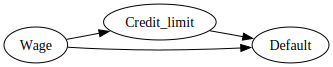

In [117]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})

g.edge("Credit_limit", "Default")
g.edge("Wage", "Default"),
g.edge("Wage", "Credit_limit")

g

이 경우 교란 요인을 포함하는 모델을 추정해야 한다.
$$
default_i=\beta_0+\beta_1 CreditLim_i + \beta_2 wage_i+e_i
$$

만약 다음처럼 교란요인이 누락된 축소모델을 추정하면 추정값은 편향된다.
$$
default_i=\beta_0+\beta_1 CreditLim_i+e_i
$$

In [118]:
biased_model = smf.ols('default~credit_limit',data=risk_data).fit()
biased_model.params['credit_limit']

-2.4019619925968776e-05

신용한도가 높아지면 채무불이행률이 낮아지는 것처럼 보이지만, 이는 현실적으로 타당하지 않은 것을 알고 있다. 하지만 **해당 편향의 크기를 정확하게 파악**할 수 있다.

회귀분석을 통해 **누락변수 편향(omitted variable bias,OVB)** 은 다음과 같이 정의할 수 있다.  
- 1.누락변수가 포함된 전체 모델의 회귀계수 더하기  

- 2.결과에 미치는 누락변수의 효과 곱하기  

- 3.누락 변수를 포함된 변수에 회귀하는 모델의 회귀계수

우선, $T$에 대한 $Y$의 단순회귀분석은 실제 인과 파라미터 $\tau$에 편향을 더한 결과이다.
$$
\frac{Cov(T,Y)}{Var(T)}=\tau+\beta_{omitted}^{'} \delta_{omitted}

이 편향식은 결과에 대한 누락된 교란요인의 회귀계수 $\beta_{omitted}^{'}$와 처치에 대한 누락변수의 회귀계수 $\delta_{omitted}$를 곱한 값이다.

다음 코드는 누락변수 편향의 공식을 구현하여, 앞서 얻은 편향된 파라미터 추정값을 확인할 수 있게 해준다.

In [120]:
long_model=smf.ols('default~credit_limit+wage',data=risk_data).fit()

omitted_model = smf.ols('wage~credit_limit',data=risk_data).fit()

(long_model.params['credit_limit'] + long_model.params['wage']*omitted_model.params['credit_limit'])

-2.4019619925968796e-05

---

## 4.9 중립 통제변수

교란 요인 $X$를 보정하면서 처치 $T$가 $Y$에 미치는 영향을 알고 싶다면 모델에 $X$를 포함하면 된다. 또 다른 방법으로는 $X$를 사용해 $T$를 예측한 후 잔차를 구하고, 이 잔차를 편향이 제거된 처치로 사용해도 같은 결과를 얻을 수 있다. 즉, $X$를 고정한 상태에서 잔차로 $Y$를 예측하는 회귀식을 만들면 $T$와 $Y$의 관계를 알 수 있다. 그렇다면 $X$에 어떤 변수들을 포함해야 할까?

다른 변수들을 추가해 보정하는 게 좋다고 **모든 변수를 회귀 모델에 포함시키는 것은 바람직하지 않다.** 공통 효과(충돌부)와 매개자는 선택편향을 유발할 수 있으므로 포함시키지 않는 것이 좋다. 하지만 회귀분석에서 고려해야 할 다른 유형의 통제변수가 있다. 일부 변수가 무해해 보이지만, 실제로는 해로울 수 있는 통제변수들이다. 이러한 통제변수는 회귀분석 추정에서 편향에 미치치 않는다는 점에서 **중립적**이라고 한다. 하지만 **분산**에는 심각한 영향을 줄 수 있다. 회귀모델에서 특정 변수를 포함할 때는 편향-분산 트레이드오프가 존재한다.

다음 그래프를 살펴본다.

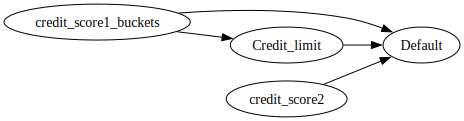

In [121]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})

g.edge("credit_score1_buckets", "Default"),
g.edge("credit_score1_buckets", "Credit_limit"),
g.edge("credit_score2", "Default"),
g.edge("Credit_limit", "Default")

g

`credit_score2`를 포함하면 어떤 결과가 나오는지 살펴본다.

In [123]:
formula = 'default~credit_limit+C(credit_score1_buckets)+credit_score2'

model = smf.ols(formula,data=risk_rnd_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5576,0.055,10.132,0.000,0.450,0.665
C(credit_score1_buckets)[T.200],-0.0387,0.055,-0.710,0.478,-0.146,0.068
C(credit_score1_buckets)[T.400],-0.1032,0.054,-1.898,0.058,-0.210,0.003
C(credit_score1_buckets)[T.600],-0.1410,0.055,-2.574,0.010,-0.248,-0.034
C(credit_score1_buckets)[T.800],-0.1161,0.057,-2.031,0.042,-0.228,-0.004
C(credit_score1_buckets)[T.1000],-0.0430,0.090,-0.479,0.632,-0.219,0.133
credit_limit,4.928e-06,1.93e-06,2.551,0.011,1.14e-06,8.71e-06
credit_score2,-0.0007,2.34e-05,-30.225,0.000,-0.001,-0.001


먼저 `credit_limit`의 파라미터 추정값이 조금 커졋다. 하지만 표준오차가 감소했다. `credit_score2`가 결과 $Y$를 잘 예측하고 선형회귀의 잡음 제거 단계에 기여하기 때문이다. *FWL*의 마지막 단계가 `credit_score2`를 포함하므로 $\tilde{Y}$의 분산이 감소하고 이를 $\tilde{Y}$에 회귀식을 만들면 더 정확한 결과를 얻는다.

<div style="border: 2px solid rgb(233, 224, 222); padding: 10px; background-color: rgb(233, 224, 222); margin: 10px 0;">
    <strong style="font-weight: bold;">● 다른 잡음 제거 기법</strong><br>
    마이크로소프트에서 개발하여 여러 IT 회사에서 사용하는 <b><a href="https://exp-platform.com/Documents/2013-02-CUPED-ImprovingSensitivityOfControlledExperiments.pdf" target="_blank">CUPED</a></b>가 가장 잘 알려져 있다. FWL 정리의 잡음 제거 과정과 매우 유사하다.
    </div>

### 잡음 유발 통제변수

통제변수는 잡음을 줄일 수도 있지만, 반대로 잡음을 늘릴 수도 있다. 조건부 무작위 실험을 다시 생각해본다. 이번에는 신용한도가 채무불이행률이 아닌 소비에 미치는 영향을 추정하려고 한다. 이전 예제에서처럼 `credit_score1`이 주어졌을 때 신용한도는 무작위로 배정되었다. 하지만 이번에는 `credit_score1`이 교란요인이 아니라고 가정해본다. `credit_score1`은 처치의 원인이지만 결과의 원인이 아니다.

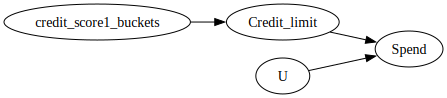

In [124]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})

g.edge("credit_score1_buckets", "Credit_limit"),
g.edge("U", "Spend"),
g.edge("Credit_limit", "Spend")

g

이는 신용한도가 소비에 미치는 인과효과를 얻으려고 `credit_score1`을 보정할 필요가 없음을 의미한다. 인과효과 추정을 위해 단순회귀만으로 충분하며, 처치 반응 함수의 비선형성을 반영하기 위해 제곱근 함수를 적용했다.

In [128]:
spend_rnd_url = 'https://raw.githubusercontent.com/matheusfacure/causal-inference-in-python-code/main/causal-inference-in-python/data/spend_data_rnd.csv'
spend_rnd_data = pd.read_csv(spend_rnd_url)

model = smf.ols('spend ~ np.sqrt(credit_limit)',data=spend_rnd_data).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2153.2154,218.600,9.850,0.000,1723.723,2582.708
np.sqrt(credit_limit),16.2915,2.988,5.452,0.000,10.420,22.163


여기에 `credit_score1_buckets`를 포함해본다.

In [129]:
model = smf.ols('spend ~ np.sqrt(credit_limit) + C(credit_score1_buckets)',data=spend_rnd_data).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2367.4867,556.273,4.256,0.000,1274.528,3460.446
C(credit_score1_buckets)[T.200],-144.7921,591.613,-0.245,0.807,-1307.185,1017.601
C(credit_score1_buckets)[T.400],-118.3923,565.364,-0.209,0.834,-1229.211,992.427
C(credit_score1_buckets)[T.600],-111.5738,570.471,-0.196,0.845,-1232.429,1009.281
C(credit_score1_buckets)[T.800],-89.7366,574.645,-0.156,0.876,-1218.791,1039.318
C(credit_score1_buckets)[T.1000],363.8990,608.014,0.599,0.550,-830.720,1558.518
np.sqrt(credit_limit),14.5953,3.523,4.142,0.000,7.673,21.518


표준오차가 증가하여 인과 파라미터의 신뢰구간이 넓어졌다. OLS는 처치의 분산이 큰 그룹을 선호하기 때문이다. 그러나 처치를 설명하는 공변량을 통제하면 효과적으로 처치에 대한 분산을 줄일 수 있다.

### 변수 선택: 편향-분산 트레이드오프

대체로 공변량이 처치에 영향을 주지만 결과에는 영향을 주지 않는 경우를 거의 찾아보기 힘들다. 대부분의 경우, $T$와 $Y$ 모두에 영향을 주는 교란요인이 있을 것이며, 이들은 서로 다른 정도로 영향을 미칠 것이다.

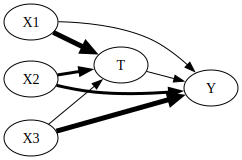

In [130]:
g = gr.Digraph(graph_attr={"rankdir": "LR"})

g.edge("X1", "T", penwidth="5"),
g.edge("X2", "T", penwidth="3"),
g.edge("X3", "T", penwidth="1"),

g.edge("X1", "Y", penwidth="1"),
g.edge("X2", "Y", penwidth="3"),
g.edge("X3", "Y", penwidth="5"),

g.edge("T", "Y"),

g

이 그래프처럼 $X_1$은 $T$의 강력한 원인이지만 $Y$의 약한 원인이고, $X_3$은 $Y$의 강력한 원인이지만 $T$의 약한 원인이다. 반면, $X_2$는 화살표의 굵기가 나타내듯이, $X_1$과 $X_3$ 중간 수준의 원인에 해당한다.

공변량은 보정해야 하는 교란요인이므로 모든 편향을 제거하려면 모든 공변량을 포함해야 한다. 하지만 처치의 원인인 공변량을 보정하면 인과 추정량의 분산이 증가한다. 위 인과 그래프를 데이터로 시뮬레이션해본다.

In [131]:
np.random.seed(123)

n=100
(x1,x2,x3) = (np.random.normal(0,1,n) for _ in range(3))
t = np.random.normal(10*x1 + 5*x2 + x3)

# 실제 ATE = 0.05
y = np.random.normal(0.05*t + x1 + 5*x2 + 10*x3,5)
df = pd.DataFrame(dict(y=y,t=t,x1=x1,x2=x2,x3=x3))

smf.ols('y~t+x1+x2+x3',data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2707,0.527,0.514,0.608,-0.775,1.316
t,0.8664,0.607,1.427,0.157,-0.339,2.072
x1,-7.0628,6.038,-1.170,0.245,-19.049,4.923
x2,0.0143,3.128,0.005,0.996,-6.195,6.224
x3,9.6292,0.887,10.861,0.000,7.869,11.389


교란요인 중 하나가 **처치**의 강력한 예측자(predictor)이고, **결과**의 약한 예측자임을 알면 모델에서 제외할 수 있다. 여기서는 $X_1$에 해당한다. 이렇게 하면 추정값이 편향될 수 있지만 분산을 크게 줄일 수 있다.

기본적으로, 모델에 더 많은 교란요인을 포함(보정)할수록 인과 추정량의 편향은 감소한다. 하지만 결과 예측력이 약한 반면, 처치 예측력이 강한 변수를 포함하면 편향이 감소하는 대신 분산이 증가하는 것을 고려해야 한다. 그리고 모든 교란요인이 동일한 영향을 주는 것이 아님을 명심해야 한다. 물론 교란요인이 $T$와 $Y$에 영향을 끼친다는 공통점이 있지만, 처치를 잘 설명하고 결과를 잘 설명하지 않는다면 보정 대상에서 배제해야 한다. 이는 회귀분석 뿐만 아니라 다음에 배울 성향점수 가중치와 같은 다른 편향 보정 방법에도 동일하게 적용된다.

인과추론에서 처치를 설명하는 데 교란요인의 영향이 어느 정도 약해야 해당 변수를 제거할 수 있는지에 대한 기준은 아직 명확히 없다. 하지만 편향-분산 트레이드오프가 존재한다는 사실을 알면 선형회귀의 매커니즘을 이해하고 설명하는 데 도움이 될 것이다.

---

## 4장 요약

4장에서는 회귀분석으로 교란요인을 보정하거나 분산을 감소하는 방법을 배웠다. 이 장의 핵심은 조건부 독립성이 유지될 때 직교화를 이용해 처치가 무작위로 배정된 것처럼 보이게 할 수 있다는 점이다.

수학적으로는 $Y_i \perp T |X$일 때 $X$로 $T$를 설명하는 회귀식을 만들고 잔차를 구해서 $X$로 인한 교란편향을 보정하는 것이다. 이러한 잔차는 **편향이 제거된 처치**로 볼 수 있다.

이 접근법은 *FWL* 정리를 활용하여 발전되었으며 다중회귀분석을 다음과 같이 세 단계로 나누어 설명할 수 있다.
- 1.**편향 제거 단계** : 처치 $T$를 교란 요인 $X$에 대해 회귀식을 만들어 처치 잔차 $\tilde{T}=T-\hat{T}$를 구한다.  

- 2.**잡음 제거 단계** : 결과 $Y$를 처치 변수 $T$가 제외된 교란 요인 $X$에 대해 회귀식을 만들어 결과 잔차 $\tilde{Y}=Y-\hat{Y}$를 구한다.  

- 3.**결과 모델 단계** : $\tilde{Y}$를 $\tilde{T}$에 대해 회귀식을 만들어 $T$가 $Y$에 미치는 인과효과를 추정한다.